# Brand Sentiment Analysis of Twitter Posts

## Setup

### Package Management

In [328]:
import os

# Install required packages for project
PACKAGES = [
    "adjustText",
    "colorama",
    "dotenv",
    "gensim",
    "ipython",
    "ipywidgets",
    "joblib",
    "matplotlib",
    "nltk",
    "numpy",
    "openai",
    "pandas",
    "preprocessor",
    "python-dotenv",
    "seaborn",
    "sklearn",
    "tqdm",
    "tweet-preprocessor",
    "wandb",
    "wordcloud",
]


def handle_packages(packages: list) -> None:
    """Quietly installs a package if it is not already installed.

    Args:
        packages (list): The list of packages to install.

    Raises:
        ImportError: If the package is not installed, install it.
    """
    for package in packages:
        try:
            __import__(package)
        except ImportError:
            os.system(f"python3 -m pip install -q {package}")


handle_packages(PACKAGES)


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [329]:
import datetime
import glob
import itertools
import json
import logging
import multiprocessing
import os
import pickle
import re
import string
import time
import warnings
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
from enum import Enum
from functools import wraps
from pprint import pprint
from queue import Queue
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from abc import ABC, abstractmethod

import dotenv
import ipywidgets as widgets
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import openai
import pandas as pd
import preprocessor
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from adjustText import adjust_text
from colorama import Fore, Style
from gensim.models import Doc2Vec, Word2Vec
from gensim.models.doc2vec import TaggedDocument
from IPython.display import Markdown, clear_output, display, display_html
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from tqdm import tqdm
from wordcloud import WordCloud

import wandb

warnings.filterwarnings("ignore")

In [330]:
# Create output folders
os.makedirs("report", exist_ok=True)
os.makedirs("logs", exist_ok=True)

In [331]:
# Handle git LFS files
def is_git_lfs_pointer(file_path):
    """
    Check if a file is a Git Large File Storage (LFS) pointer.

    Parameters:
    - file_path (str): Path to the file that needs to be checked.

    Returns:
    - bool: True if the file is a Git LFS pointer, otherwise False.

    Raises:
    - FileNotFoundError: If the provided file_path does not exist.
    - UnicodeDecodeError: If the file is not a text file and therefore not a Git LFS pointer.

    """
    try:
        with open(file_path, "r") as file:
            contents = file.read()
        return "version https://git-lfs.github.com/spec/v1" in contents
    except UnicodeDecodeError:
        # This is not a text file, so it's not a Git LFS pointer
        return False

# List of patterns to match file paths
patterns = [
    "datasets/*",
    "cache/*",
    "*.mp4",
    "Final-Project-Team-2.mp4",
]

# Iterate over each pattern to find matching files or directories
for pattern in patterns:
    files = glob.glob(pattern)
    for file in files:
        if is_git_lfs_pointer(file):
            os.system(f"git lfs pull --include={file}")

In [332]:
class Metrics:
    """
    A class to hold metrics for monitoring performance.

    This class is a singleton, meaning that there is only one instance of the class throughout the entire program.
    All functions decorated with @measure_time share the same Metrics object.

    Attributes:
        metrics (dict): A dictionary to store the metrics.
    """

    _instance = None

    def __new__(cls):
        """
        Overrides the default object creation method to implement the singleton pattern.

        Returns:
            Metrics: The singleton instance of the Metrics class.
        """
        if cls._instance is None:
            cls._instance = super(Metrics, cls).__new__(cls)
            cls._instance.metrics = {}
        return cls._instance

    def __init__(self):
        """Initializes the Metrics class with an empty dictionary."""
        self.metrics: dict[str, float] = {}

    def add_metric(self, key: str, value: float) -> None:
        """
        Adds a new metric to the dictionary or appends to an existing one.

        Args:
            key (str): The name of the metric.
            value (float): The value of the metric.
        """
        if key in self.metrics:
            self.metrics[key] += value
        else:
            self.metrics[key] = value

    def get_metrics(self) -> dict[str, float]:
        """
        Returns the dictionary of metrics.

        Returns:
            dict: The dictionary of metrics.
        """
        return self.metrics

    def __str__(self) -> str:
        """Returns a string representation of the metrics."""
        return "\n".join(f"{k}: {v}" for k, v in self.metrics.items())

    def __getitem__(self, key: str) -> float:
        """
        Returns the value of the metric with the given key.

        Args:
            key (str): The key of the metric.

        Returns:
            float: The value of the metric.
        """
        return self.metrics.get(key)

    def __setitem__(self, key: str, value: float) -> None:
        """
        Sets the value of the metric with the given key.

        Args:
            key (str): The key of the metric.
            value (float): The value of the metric.
        """
        self.metrics[key] = value

    def __len__(self) -> int:
        """
        Returns the number of metrics.

        Returns:
            int: The number of metrics.
        """
        return len(self.metrics)

    def __contains__(self, key: str) -> bool:
        """
        Checks if the metric with the given key exists.

        Args:
            key (str): The key of the metric.

        Returns:
            bool: True if the metric exists, False otherwise.
        """
        return key in self.metrics

    def clear_metrics(self) -> None:
        """Clears all the metrics."""
        self.metrics.clear()

    def remove_metric(self, key: str) -> None:
        """
        Removes the metric with the given key.

        Args:
            key (str): The key of the metric.
        """
        if key in self.metrics:
            del self.metrics[key]

    def update_metric(self, key: str, value: float) -> None:
        """
        Updates the value of the metric with the given key.

        Args:
            key (str): The key of the metric.
            value (float): The new value of the metric.
        """
        if key in self.metrics:
            self.metrics[key] = value

    def print_metrics(self) -> None:
        """Prints all the metrics in a nice format."""
        print("Metrics:")
        sorted_metrics = sorted(
            self.metrics.items(), key=lambda item: item[1], reverse=True
        )
        for key, value in sorted_metrics:
            print(f"  {key}: {value:.2f} seconds")
        print(f"Total time: {sum(self.metrics.values()):.2f} seconds")


def measure_time(run_name: str):
    """
    A decorator factory that measures the time taken by a function and logs it to the Metrics singleton.

    Args:
        run_name (str): The name of the run. This is used to differentiate metrics among different runs.

    Returns:
        Callable: The decorator that wraps the function with timing and logging.
    """

    def decorator(func: Callable[..., Any]) -> Callable[..., Any]:
        """
        The actual decorator that wraps the function with timing and logging.

        Args:
            func (Callable): The function to be timed and logged.

        Returns:
            Callable: The wrapped function.
        """

        def wrapper(*args, **kwargs):
            """
            The wrapper function that adds timing and logging to the original function.

            Args:
                *args: The positional arguments for the original function.
                **kwargs: The keyword arguments for the original function.

            Returns:
                The result of the original function.
            """
            # START TIMER
            start_time = time.time()
            # CALL FUNCTION
            result = func(*args, **kwargs)
            # CALCULATE ELAPSED TIME
            total_time = time.time() - start_time
            # LOG RESULT
            metrics.add_metric(f"{run_name}", total_time)
            print(f"{run_name}...{total_time:.2f} seconds")
            return result

        return wrapper

    return decorator


metrics = Metrics()

### Setting Up Data Analysis and Visualization Tools


In [333]:
# Configure
pd.set_option("display.max_colwidth", 80)

# Set matplotlib style to 'fivethirtyeight'
plt.style.use("fivethirtyeight")

### Loading Environment Variables

In [334]:
# Load environment variables
ENVIRONMENT = dotenv.dotenv_values()
for key in ENVIRONMENT:
    os.environ[key] = ENVIRONMENT[key]

## Exploratory Data Analysis (EDA)

### Retrieving and Preparing the Sentiment140 Dataset

In [335]:
tweets_df = pd.read_csv(
    "datasets/training.1600000.processed.noemoticon.csv",
    encoding="ISO-8859-1",
    names=["sentiment", "ids", "date", "flag", "user", "tweet"],
    header=None,
)

# Get tweets and sentiment labels
tweets_df = tweets_df[["tweet", "sentiment"]]

# Remap sentiment labels to 0 = negative, 1 = positive (instead of 0 = negative, 4 = positive)
tweets_df.sentiment = tweets_df.sentiment.replace(4, 1)

### Class Balance

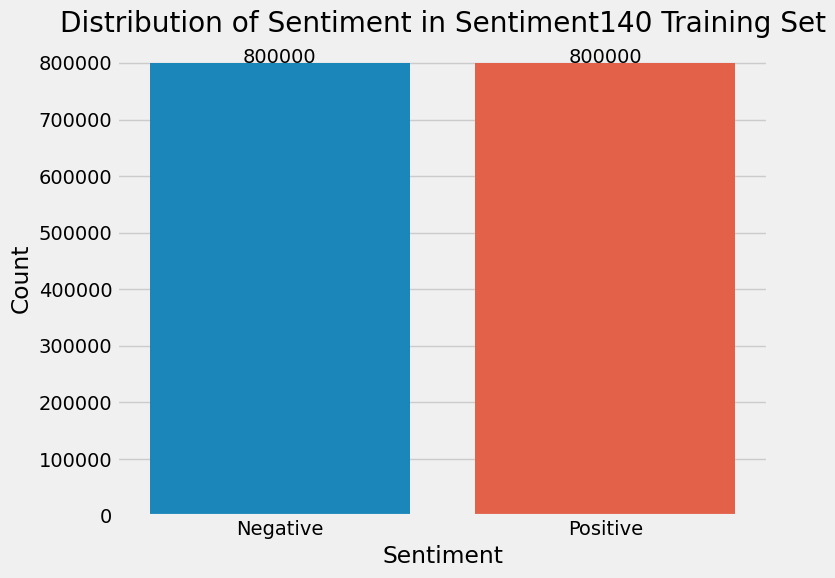

In [336]:
# Show sentiment distribution in tweets_df
distribution = tweets_df.sentiment.value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=distribution.index, y=distribution.values)
plt.title("Distribution of Sentiment in Sentiment140 Training Set")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks([0, 1], ["Negative", "Positive"])

for i, v in enumerate(distribution.values):
    # Add counts above bars
    plt.text(i, v, str(v), ha="center")

# Save visualization
plt.tight_layout()
plt.savefig("report/sentiment_distribution.png", dpi=300)

plt.show()

### Word Cloud


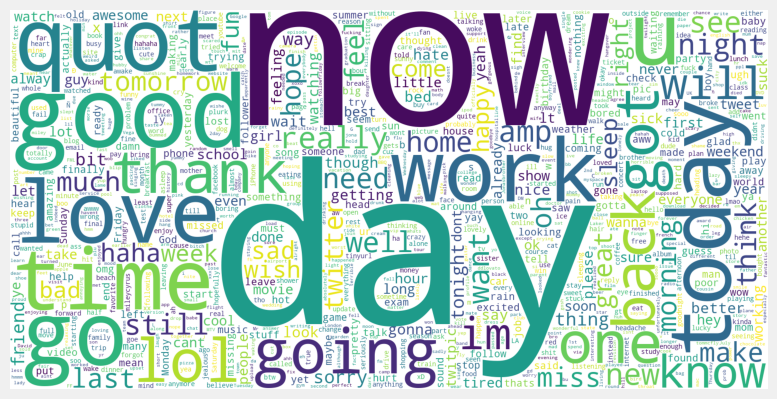

generating word cloud from training data...14.69 seconds


In [337]:
@measure_time("generating word cloud from training data")
def generate_wordcloud(df_train):
    """
    Generate a wordcloud from a dataframe.

    Args:
        df_train (DataFrame): The dataframe containing the text data.

    Returns:
        None
    """
    wordcloud = WordCloud(
        width=1600,
        height=800,
        background_color="white",
        min_font_size=10,
        max_words=1000,
        collocations=False,
        random_state=42,  # set for idempotency
    )

    wordcloud.generate(" ".join(df_train.tweet.tolist()))

    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud)
    plt.axis("off")

    # Save visualization
    plt.tight_layout()
    plt.savefig("report/wordcloud.png", dpi=300)

    plt.show()


generate_wordcloud(tweets_df)

## Preprocessing

### Process Tweets to Identify Brand Mentions

In [338]:
# Define lists of brands for brand classifier
BRANDS = [
    "facebook",
    "google",
    "apple",
    "starbucks",
    "disney",
    "microsoft",
    "target",
    "amazon",
    "walmart",
    "sony",
]

In [339]:
# Calculate frequency of each brand in the tweets
counter = Counter(
    word
    for tweet in tweets_df.tweet
    for word in tweet.lower().split()
    if word in BRANDS
)

# Create dataframe for brand frequencies
brand_freqs_df = pd.DataFrame(
    counter.items(), columns=["brand", "frequency"]
).sort_values("frequency", ascending=False)

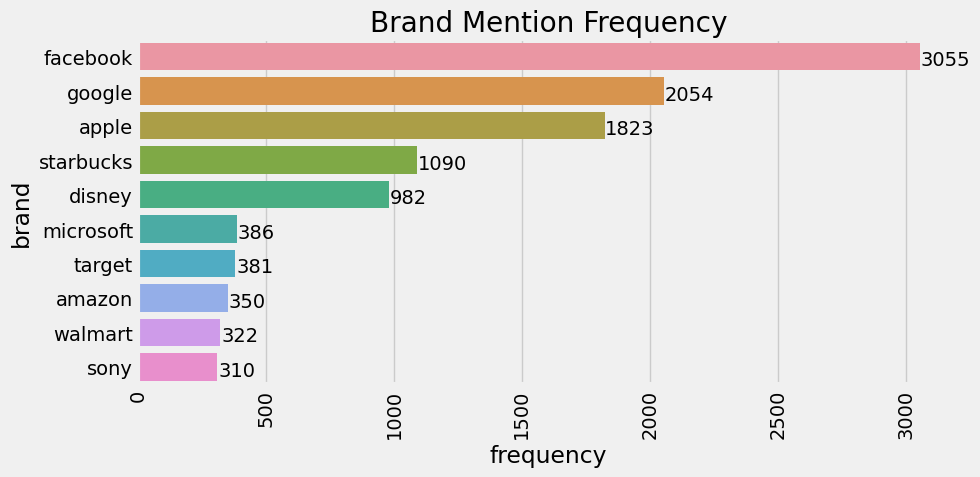

In [340]:
# Create barplot to visualize brand mention frequency
num_brands = len(brand_freqs_df)
plt.figure(figsize=(10, num_brands * 0.5))
barplot = sns.barplot(
    x="frequency", y="brand", data=brand_freqs_df, order=brand_freqs_df.brand
)
plt.xticks(rotation=90)
plt.title("Brand Mention Frequency")

# Add counts at the ends of the bars
for i, v in enumerate(brand_freqs_df.frequency):
    barplot.text(v + 3, i + 0.25, str(v))

# Save visualization
plt.tight_layout()
barplot.figure.savefig("report/brand_mention_frequency.png", dpi=300)

plt.show()

### Create brands dataset



In [341]:
@measure_time("creating brands dataframe")
def create_brand_dataframe(tweets_df: pd.DataFrame, brands: List[str]) -> pd.DataFrame:
    """
    Create a new dataframe with brand labels.

    Args:
        tweets_df (pd.DataFrame): The dataframe containing tweets and sentiments.
        brands (List[str]): The list of brands to be searched in the tweets.

    Returns:
        pd.DataFrame: The new dataframe with brand labels.
    """
    brand_rows = []
    non_brand_counter = 0
    brand_counter = 0
    for tweet, sentiment in zip(tweets_df.tweet, tweets_df.sentiment):
        tweet_tokens = tweet.lower().split()
        brand_found = False

        # Check if any words in the tweet are brands
        for word in tweet_tokens:
            word = word.replace("-", "")
            for brand in BRANDS:
                # If a brand is found, tag this tweet with the brand name
                if word == brand:
                    brand_rows.append(
                        {"tweet": tweet, "brand": brand, "sentiment": sentiment}
                    )
                    brand_found = True
                    brand_counter += 1
                    break

            # If a brand was already found in this tweet, move on to the next tweet
            if brand_found:
                break
        
        # For every brand tweet added, also add a row with no brand for balance
        if not brand_found and non_brand_counter < brand_counter:
            brand_rows.append(
                {"tweet": tweet, "brand": "nobrand", "sentiment": sentiment}
            )
            non_brand_counter += 1

    # Create new dataframe with the labeled brand data
    brands_df = pd.DataFrame(brand_rows, columns=["tweet", "brand", "sentiment"])
    return brands_df


brands_df = create_brand_dataframe(tweets_df, BRANDS)
brands_df["sentiment"] = brands_df["sentiment"].astype(int)
display(brands_df.head())

creating brands dataframe...5.56 seconds


,tweet,brand,sentiment
0,is upset that he can't update his Facebook by texting it... and might cry as...,facebook,0
1,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,nobrand,0
2,amazon s3 plugin not worked in my website . it need PHP 5 . but my hosting p...,amazon,0
3,"Argh! I was suuuper sleepy an hour ago, now I'm wide awake. Hope I don't st...",nobrand,0
4,Nasty budget due and my iphone is being sent to Apple today.,apple,0


### Data Generation Using OpenAI's GPT-4 Model

In [342]:
logging.basicConfig(filename="logs/data_generator.log", level=logging.INFO)


class Status(Enum):
    NOT_STARTED = "NOT_STARTED"
    QUEUED = "QUEUED"
    BALANCING = "BALANCING"
    BALANCED = "BALANCED"


class JobAction(Enum):
    GENERATE = "GENERATE"


class Job:
    def __init__(self, brand: str, sentiment: str, action: JobAction, count: int):
        """
        Initialize a Job object.

        Args:
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            action (JobAction): The action to be performed.
            count (int): The count of the action.
        """
        self.brand = brand
        self.sentiment = sentiment
        self.action = action
        self.count = count

    def __str__(self):
        return f"Job(brand={self.brand}, sentiment={self.sentiment}, action={self.action}, count={self.count})"


class DataGenerator:
    def __init__(
        self,
        brands: List[str],
        model: str = "gpt-4",
        samples_per_brand: int = 100,
        cache_file: str = "cache/generated_data.pkl",
    ):
        """
        Initialize a DataGenerator object.

        Args:
            brands (List[str]): The list of brands.
            model (str, optional): The model to be used. Defaults to "gpt-4".
            samples_per_brand (int, optional): The number of samples per brand. Defaults to 100.
            cache_file (str, optional): The cache file to be used. Defaults to "cache/generated_data.pkl".
        """
        logging.info("Initializing DataGenerator")
        self.brands = brands
        self.model = model
        self.samples_per_brand = samples_per_brand
        self.dataset_size = samples_per_brand * (len(brands) * 2 + 1)
        self.dataset = []
        self.seen_data = set()
        self.brand_counts = {brand: {"positive": 0, "negative": 0} for brand in brands}
        self.brand_status = {brand: Status.NOT_STARTED for brand in brands}
        openai.api_key = os.environ["OPENAI_API_KEY"]
        self.cache_file = cache_file
        self.load_or_initialize_dataset()
        self.delete_excess_data()
        self.job_list = []

    def add_job(self, brand: str, sentiment: str, action: JobAction):
        """
        Add a job to the job list.

        Args:
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            action (JobAction): The action to be performed.
        """
        count = self.calculate_job_count(brand, sentiment, action.value.lower())
        job = Job(brand, sentiment, action, count)
        self.job_list.append(job)
        logging.info(f"Job added: {job}")

    def calculate_jobs(self):
        """
        Calculate the jobs to be performed.
        """
        logging.info("Calculating jobs")
        for brand in self.brands:
            for sentiment in ["positive", "negative"]:
                current_count = self.brand_counts[brand][sentiment]
                target_count = self.get_target_count(brand)
                if (
                    current_count < target_count
                    and self.brand_status[brand] != Status.BALANCED
                ):
                    self.add_job(brand, sentiment, JobAction.GENERATE)
                elif (
                    current_count > target_count
                    and self.brand_status[brand] != Status.BALANCED
                ):
                    self.delete_excess_data()
        self.report_metrics()

    def process_jobs(self):
        """
        Process the jobs in the job list.
        """
        logging.info("Processing jobs")
        while self.job_list:
            job = self.job_list.pop(0)
            if self.brand_status[job.brand] != Status.BALANCED:
                self.process_job(job)

    def process_job(self, job: Job):
        """
        Process a job.

        Args:
            job (Job): The job to be processed.
        """
        logging.info(f"Processing job: {job}")
        self.update_status(job.brand, Status.BALANCING)
        if job.action == JobAction.GENERATE:
            self.generate_brand_data(job.brand, job.sentiment, job.count)
        self.delete_excess_data()
        self.update_status(job.brand, Status.BALANCED)
        self.report_metrics()

    def calculate_job_count(self, brand: str, sentiment: str, action: str) -> int:
        """
        Calculate the job count.

        Args:
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            action (str): The action to be performed.

        Returns:
            int: The job count.
        """
        logging.info(
            f"Calculating job count for brand: {brand}, sentiment: {sentiment}, action: {action}"
        )
        if action == JobAction.GENERATE:
            return self.get_target_count(brand) - self.brand_counts[brand][sentiment]

    def balance(self):
        """
        Generate a balanced dataset.
        """
        logging.info("Generating balanced dataset")
        self.calculate_jobs()
        self.process_jobs()

    def update_status(self, brand: str, status: Status):
        """
        Update the status of a brand.

        Args:
            brand (str): The brand name.
            status (Status): The status to be updated.
        """
        logging.info(f"Updating status for brand: {brand} to {status}")
        self.brand_status[brand] = status
        self.report_metrics()

    def generate_brand_data(self, brand: str, sentiment: str, count: int = None):
        """
        Generate data for a brand.

        Args:
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            count (int, optional): The count of the data to be generated. Defaults to None.
        """
        logging.info(f"Generating {sentiment} data for brand: {brand}")
        target_count = self.get_target_count(brand)
        while self.brand_counts[brand][sentiment] < target_count:
            remaining = target_count - self.brand_counts[brand][sentiment]
            self.generate_and_add_data_until_target(brand, sentiment, remaining)
            self.save_generated_data()
            self.report_metrics(brand)

    def get_target_count(self, brand: str) -> int:
        """
        Get the target count for a brand.

        Args:
            brand (str): The brand name.

        Returns:
            int: The target count.
        """
        return self.samples_per_brand // 2

    def generate_and_add_data_until_target(
        self, brand: str, sentiment: str, remaining: int
    ):
        """
        Generate and add data until the target count is reached.

        Args:
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            remaining (int): The remaining count to reach the target.
        """
        while remaining > 0:
            chunks = min(remaining, 50)
            user_prompt = self.create_prompt(brand, sentiment, chunks)
            self.generate_and_add_data(user_prompt, brand, sentiment, chunks)
            remaining = (
                self.get_target_count(brand) - self.brand_counts[brand][sentiment]
            )

    def generate_and_add_data(
        self,
        user_prompt: str,
        brand: str,
        sentiment: str,
        count: int,
        max_retries: int = 3,
    ):
        """
        Generate and add data to the dataset.

        Args:
            user_prompt (str): The user prompt.
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            count (int): The count of the data to be generated.
            max_retries (int, optional): The maximum number of retries. Defaults to 3.
        """
        logging.info(
            f"Generating and adding data for brand: {brand}, sentiment: {sentiment}"
        )
        retries = 0
        while retries < max_retries:
            data = self.generate_data_from_api(user_prompt, count)
            data = data.split("\n")
            valid_data = [item for item in data if len(item.split("|||")) >= 3]
            if len(valid_data) > 0:
                self.add_valid_data_to_dataset(valid_data, brand, sentiment)
                self.save_generated_data()
                break
            else:
                retries += 1
        if retries == max_retries:
            logging.error(
                f"Failed to generate valid data for {brand} after {max_retries} attempts."
            )
        self.report_metrics(brand)

    def add_valid_data_to_dataset(self, valid_data: list, brand: str, sentiment: str):
        """
        Add valid data to the dataset.

        Args:
            valid_data (list): The valid data to be added.
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
        """
        logging.info(
            f"Adding valid data to dataset for brand: {brand}, sentiment: {sentiment}"
        )
        for item in valid_data:
            if len(self.dataset) >= self.dataset_size:
                break
            item_parts = item.split("|||")
            item_brand = item_parts[1].lower()
            if item_brand not in self.brand_counts:
                continue
            item_sentiment = "positive" if item_parts[2] == "1" else "negative"
            item_parts[1] = item_brand
            item = "|||".join(item_parts)
            if item not in self.seen_data:
                self.dataset.append(item)
                self.seen_data.add(item)
                self.brand_counts[item_brand][sentiment] += 1

    def create_prompt(self, brand: str, sentiment: str, count: int) -> str:
        """
        Create a prompt.

        Args:
            brand (str): The brand name.
            sentiment (str): The sentiment of the brand.
            count (int): The count of the data to be generated.

        Returns:
            str: The created prompt.
        """
        logging.info(f"Creating prompt for brand: {brand}, sentiment: {sentiment}")
        if sentiment == "positive":
            return self.create_positive_prompt(brand, count)
        else:
            return self.create_negative_prompt(brand, count)

    def create_positive_prompt(self, brand: str, count: int) -> str:
        """
        Create a positive prompt.

        Args:
            brand (str): The brand name.
            count (int): The count of the data to be generated.

        Returns:
            str: The created prompt.
        """
        logging.info(f"Creating positive prompt for brand: {brand}")
        return f"""
            Create some random data that only mention the brand {brand} in the format: 
            "tweet"|||brand|||sentiment 
            where:
                tweet is a Twitter post, 
                brand is {brand}, and
                sentiment is 1 indicating positive sentiment of the tweet.

            EXAMPLES (with other brands)
                "My Taco Bell was great guys"|||taco bell|||1
                "Big thanks to our friends at Hattiesburg Coca-Cola for the banner celebrating R6's run to the national championship. We appreciate your support! Banner is on display in the Cook Union, stop by and see it!"|||coca cola|||1

            AIM: Try to come up with a diverse dataset of tweets that mention brand {brand} and are positive.

            Create {count} data points.
            """

    def create_negative_prompt(self, brand: str, count: int) -> str:
        """
        Create a negative prompt.

        Args:
            brand (str): The brand name.
            count (int): The count of the data to be generated.

        Returns:
            str: The created prompt.
        """
        logging.info(f"Creating negative prompt for brand: {brand}")
        return f"""
            Create some random data that only mention the brand {brand} in the format: 
            "tweet"|||brand|||sentiment 
            where
                tweet is a Twitter post, 
                brand is {brand}, and
                sentiment is 0 indicating negative sentiment of the tweet.

            EXAMPLES (with other brands)
                "It's taken me years, up to this moment, to realize my Gibson guitar sucks ass"|||gibson|||0
                "ppl at netflix are making a lot of really fucking dumb decisions like...way too often. like they got a bad idea assembly line just cranking out mistakes"|||netflix|||0

            AIM: Try to come up with a diverse dataset of tweets that mention the brand {brand} and are negative.

            Create {count} data points.
            """

    def generate_data_from_api(self, user_prompt: str, count: int) -> str:
        """
        Generate data from the API.

        Args:
            user_prompt (str): The user prompt.
            count (int): The count of the data to be generated.

        Returns:
            str: The generated data.
        """
        if count is None:
            count = 50
        logging.info(f"Generating data with prompt: {user_prompt}")
        wait_time = 5
        retries = 0
        while retries < 3:
            try:
                chat_completion = openai.ChatCompletion.create(
                    model=self.model,
                    temperature=0.4,
                    max_tokens=count * 50,
                    messages=[
                        {"role": "user", "content": user_prompt},
                    ],
                )
                return chat_completion.choices[0].message.content
            except openai.OpenAIError as e:
                if "Rate limit exceeded" in str(e) or "Bad Gateway" in str(e):
                    logging.error(
                        f"Error: {str(e)}. Retrying in {wait_time} seconds..."
                    )
                    print(f"Error: {str(e)}. Retrying in {wait_time} seconds...")
                    time.sleep(wait_time)
                    wait_time *= 2
                    retries += 1
                else:
                    logging.error(f"Unexpected error: {str(e)}")
                    raise e
        logging.error("Failed to generate data after 3 retries.")
        raise Exception("Failed to generate data after 3 retries.")

    def load_or_initialize_dataset(self):
        """
        Load or initialize the dataset.
        """
        logging.info("Loading or initializing dataset")
        if os.path.exists(self.cache_file):
            self.load_generated_data(self.cache_file)
        else:
            self.initialize_dataset()
            self.save_generated_data()

    def initialize_dataset(self):
        """
        Initialize the dataset.
        """
        logging.info("Initializing dataset")
        self.dataset = []
        self.seen_data = set()
        self.brand_counts = {
            brand: {"positive": 0, "negative": 0} for brand in self.brands
        }

    def save_generated_data(self):
        """
        Save the generated data.
        """
        logging.info("Saving generated data")
        with open(self.cache_file, "wb") as f:
            pickle.dump(self.dataset, f)

    def load_generated_data(self, filename: str):
        """
        Load the generated data.

        Args:
            filename (str): The filename of the data to be loaded.
        """
        logging.info(f"Loading generated data from file: {filename}")
        with open(filename, "rb") as f:
            loaded_data = pickle.load(f)
        if isinstance(loaded_data, list):
            self.dataset = [
                data
                for data in loaded_data
                if data.split("|||")[1].lower() in self.brand_counts
            ]
            self.update_counts()
        else:
            logging.error(
                "Loaded data is not in the expected format (list), initializing a new dataset."
            )
            self.initialize_dataset()

    def update_counts(self):
        """
        Update the counts of the data.
        """
        logging.info("Updating counts")
        for data in self.dataset:
            parts = data.split("|||")
            if len(parts) < 3:
                continue
            brand = parts[1].lower()
            sentiment = "positive" if parts[2] == "1" else "negative"
            if brand in self.brand_counts:
                self.brand_counts[brand][sentiment] += 1

    def report_metrics(self, last_updated_brand: str = None):
        """
        Report the metrics.

        Args:
            last_updated_brand (str, optional): The last updated brand. Defaults to None.
        """
        logging.info("Reporting metrics")
        clear_output(wait=True)

        brands = []
        positive_counts = []
        negative_counts = []
        status = []

        for brand in self.brand_counts.keys():
            brands.append(brand)
            positive_counts.append(
                f"{self.brand_counts[brand]['positive']}/{self.get_target_count(brand)}"
            )
            negative_counts.append(
                f"{self.brand_counts[brand]['negative']}/{self.get_target_count(brand)}"
            )
            status.append(self.get_status(brand))

        df_brands = pd.DataFrame(
            {
                "Brands": brands,
                "Positive Counts": positive_counts,
                "Negative Counts": negative_counts,
                "Status": status,
            }
        )

        df_jobs = pd.DataFrame(
            [
                (job.brand, job.sentiment, job.action.name, job.count)
                for job in self.job_list
            ],
            columns=["Brand", "Sentiment", "Action", "Count"],
        )

        df1_styler = df_brands.style.set_table_attributes(
            "style='display:inline; vertical-align:top'"
        ).set_caption("Brands")

        df2_styler = df_jobs.style.set_table_attributes(
            "style='display:inline; vertical-align:top'"
        ).set_caption("Jobs")

        display_html(
            df1_styler._repr_html_() + df2_styler._repr_html_(),
            raw=True,
        )

    def get_status(self, brand: str) -> str:
        """
        Get the status of a given brand.

        Args:
            brand (str): The brand name.

        Returns:
            str: The status of the brand.
        """
        logging.info(f"Getting status for brand: {brand}")
        if brand is None:
            return Status.NOT_STARTED
        else:
            target_count = self.get_target_count(brand)
            if (
                self.brand_counts[brand]["positive"] == target_count
                and self.brand_counts[brand]["negative"] == target_count
            ):
                return Status.BALANCED
            elif (
                self.brand_counts[brand]["positive"] > 0
                or self.brand_counts[brand]["negative"] > 0
            ):
                return Status.BALANCING
            else:
                return Status.QUEUED

    def delete_excess_data(self):
        """
        Delete excess data from the dataset.
        """
        logging.info("Deleting excess data")
        loop_counter = 0
        max_loops = 10000

        for brand in self.brands:
            for sentiment in ["positive", "negative"]:
                target_count = self.get_target_count(brand)
                while self.brand_counts[brand][sentiment] > target_count:
                    logging.info(
                        f"Deleting excess data for brand: {brand}, sentiment: {sentiment}"
                    )
                    found = False
                    for i in range(len(self.dataset) - 1, -1, -1):
                        parts = self.dataset[i].split("|||")
                        if len(parts) < 3:
                            continue
                        data_brand = parts[1]
                        data_sentiment = "positive" if parts[2] == "1" else "negative"
                        if data_brand == brand and data_sentiment == sentiment:
                            del self.dataset[i]
                            self.brand_counts[brand][sentiment] -= 1
                            found = True
                            break
                    if not found:
                        logging.error(
                            f"No matching data points found for brand: {brand}, sentiment: {sentiment}"
                        )
                        break
                    loop_counter += 1
                    if loop_counter >= max_loops:
                        logging.error("Reached maximum number of loops, breaking...")
                        break

In [343]:
data_generator = DataGenerator(BRANDS, samples_per_brand=400)
data_generator.balance()

,Brands,Positive Counts,Negative Counts,Status
0,facebook,200/200,200/200,Status.BALANCED
1,google,200/200,200/200,Status.BALANCED
2,apple,200/200,200/200,Status.BALANCED
3,starbucks,200/200,200/200,Status.BALANCED
4,disney,200/200,200/200,Status.BALANCED
5,microsoft,200/200,200/200,Status.BALANCED
6,target,200/200,200/200,Status.BALANCED
7,amazon,200/200,200/200,Status.BALANCED
8,walmart,200/200,200/200,Status.BALANCED
9,sony,200/200,200/200,Status.BALANCED


### Processing and Integrating Generated Data

In [344]:
# Load the data
data_generator.load_generated_data("cache/generated_data.pkl")

# Convert the data into a DataFrame
data = [item.split("|||") for item in data_generator.dataset]
print(len(data))

generated_data = pd.DataFrame(data, columns=["tweet", "brand", "sentiment"])
generated_data["sentiment"] = generated_data["sentiment"].astype(int)

print(generated_data.sentiment.value_counts())

4001
0    2001
1    2000
Name: sentiment, dtype: int64


In [345]:
# Be careful not to run this multiple times without resetting brands_df, it will add duplicate entries
brands_df = pd.concat([brands_df, generated_data], ignore_index=True)

In [346]:
print(f"brands_df.shape: {brands_df.shape}")

brands_df.shape: (25141, 3)


In [347]:
print(f"brands_df.brand.value_counts(): {brands_df.brand.value_counts()}")

brands_df.brand.value_counts(): nobrand      10570
facebook      3413
google        2370
apple         2170
starbucks     1477
disney        1359
walmart        799
target         774
microsoft      772
amazon         741
sony           696
Name: brand, dtype: int64


In [348]:
print(f"brands_df.tail(6): \n{brands_df.tail(6)}")

brands_df.tail(6): 
                                                                          tweet  \
25135             "Sony's speakers are the worst. The sound keeps cutting out."   
25136                  "I hate my Sony TV. The remote control is so confusing."   
25137      "Sony's headphones are so overpriced. They are not worth the money."   
25138                   "My Sony laptop is so slow. I can't get any work done."   
25139                       "Sony's camera is so bad. The focus is always off."   
25140  "The Sony gaming console is so bad. The controller keeps disconnecting."   

      brand  sentiment  
25135  sony          0  
25136  sony          0  
25137  sony          0  
25138  sony          0  
25139  sony          0  
25140  sony          0  


In [349]:
# Write dataset to file
print(len(brands_df))
brands_df.to_csv("datasets/brands.csv", index=False)

25141


### Brand Mention Distribution Visualization

Brand       14571
No Brand    10570
Name: brand, dtype: int64


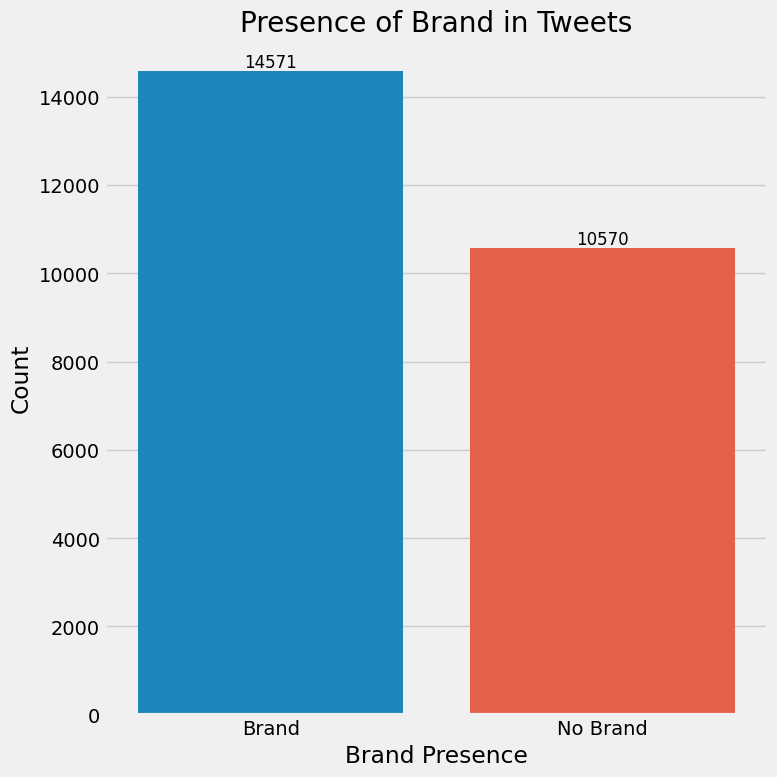

In [350]:
# Get counts of brand_presence
brand_presence = brands_df["brand"].apply(
    lambda x: "No Brand" if x == "nobrand" else "Brand"
)
print(brand_presence.value_counts())

counts = brand_presence.value_counts().reset_index()

# Plot counts of tweets with a brand and tweets with no brand
plt.figure(figsize=(8, 8))
ax = sns.barplot(x="index", y=brand_presence.name, data=counts)
plt.title("Presence of Brand in Tweets")
plt.ylabel("Count")
plt.xlabel("Brand Presence")


for p in ax.patches:
    # Add counts to bars
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        p.get_height(),
        "%d" % int(p.get_height()),
        fontsize=12,
        color="black",
        ha="center",
        va="bottom",
    )

# Save visualization
plt.tight_layout()
plt.savefig("report/brand_count.png", dpi=300)

plt.show()

nobrand      10570
facebook      3413
google        2370
apple         2170
starbucks     1477
disney        1359
walmart        799
target         774
microsoft      772
amazon         741
sony           696
Name: brand, dtype: int64


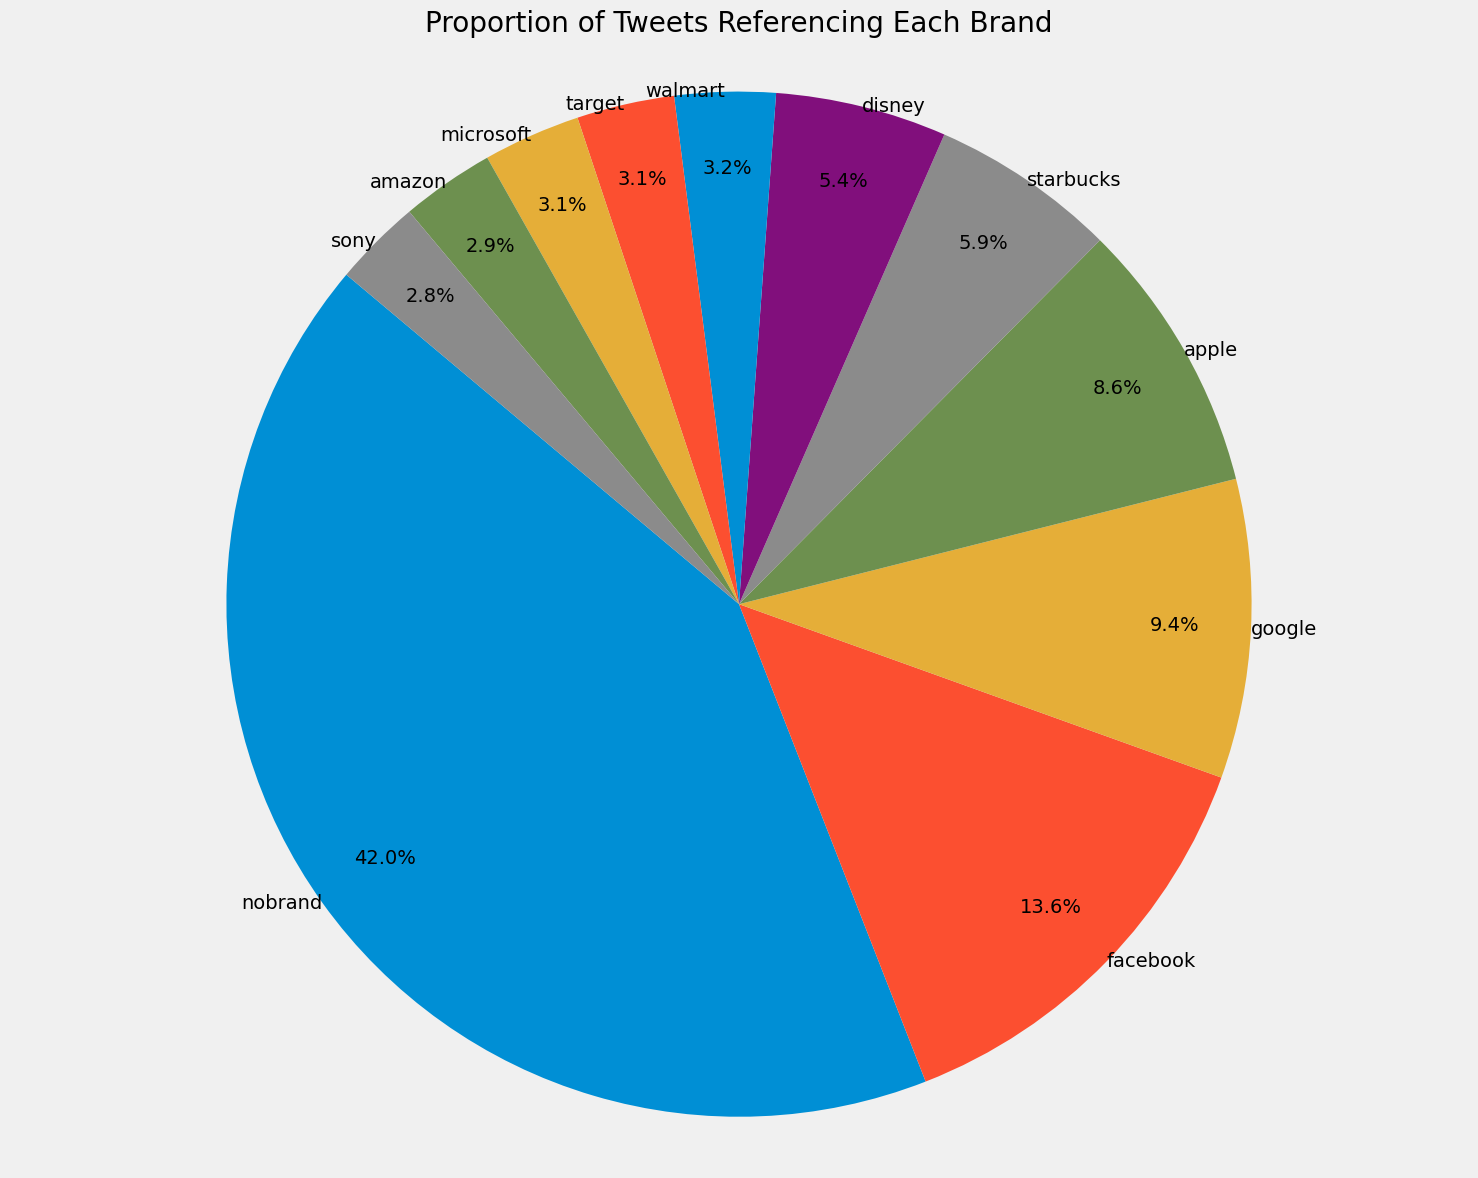

In [351]:
# Plot brand count proportions
brand_counts = brands_df["brand"].value_counts()
print(brand_counts)

plt.figure(figsize=(15, 12))
plt.pie(
    brand_counts,
    labels=brand_counts.index,
    autopct="%1.1f%%",
    startangle=140,
    pctdistance=0.85,
    labeldistance=1,
)
plt.axis("equal")
plt.title("Proportion of Tweets Referencing Each Brand")

# Save visualization
plt.tight_layout()
plt.savefig("report/proportion_brands_in_tweets.png", dpi=300)

plt.show()

In [352]:
# Remove n random samples from brands_df to use for testing the brand sentiment analyzer 
bsa_test_data = brands_df.sample(n=200)

print(bsa_test_data.brand.value_counts())

brands_df.drop(bsa_test_data.index, inplace=True)

nobrand      80
facebook     32
google       20
apple        17
starbucks    12
disney       11
walmart       7
amazon        6
microsoft     5
sony          5
target        5
Name: brand, dtype: int64


In [353]:
print(brands_df.shape)

(24941, 3)


In [354]:
# PUNKT TOKENIZER FOR SENTENCE TOKENIZATION
nltk.download("punkt", quiet=True)

# TAGGER FOR PART-OF-SPEECH TAGGING
nltk.download("averaged_perceptron_tagger", quiet=True)

# CHUNKER FOR NAMED ENTITY RECOGNITION
nltk.download("maxent_ne_chunker", quiet=True)

# CORPUS OF WORDS FOR SPELLCHECKING OR LANGUAGE IDENTIFICATION
nltk.download("words", quiet=True)

# MULTILINGUAL LEXICAL DATABASE
nltk.download("omw-1.4", quiet=True)

# DOWNLOAD STOPWORDS CORPUS
nltk.download("stopwords", quiet=True)

# CREATE SET OF ENGLISH STOPWORDS FOR FASTER MEMBERSHIP CHECKING
STOP_WORDS = set(stopwords.words("english"))

### Preprocessing Tweets for Text Analysis


In [355]:
# Downloading tokenizer for sentence tokenization
nltk.download("punkt", quiet=True)

# Downloading tagger for part-of-speech tagging
nltk.download("averaged_perceptron_tagger", quiet=True)

# Downloading chunker for named entity recognition
nltk.download("maxent_ne_chunker", quiet=True)

# Downloading corpus of words for spellchecking or language identification
nltk.download("words", quiet=True)

# Downloading multilingual lexical database
nltk.download("omw-1.4", quiet=True)

# Downloading stopwords corpus
nltk.download("stopwords", quiet=True)

# Creating a set of English stopwords for faster membership checking
STOP_WORDS = set(stopwords.words("english"))

In [356]:
# Set options to remove URLs and @mentions
preprocessor.set_options(preprocessor.OPT.URL, preprocessor.OPT.MENTION)

# Initialize stemmer
STEMMER = SnowballStemmer("english")

# Convert stopwords and punctuation to sets
STOP_WORDS_SET = set(STOP_WORDS)
PUNCTUATION_SET = set(string.punctuation)


def preprocess(tweet: str) -> list:
    """
    Function to preprocess a tweet by removing URLs, @mentions, stopwords, and punctuation.
    It also tokenizes and stems the tweet.
    
    Args:
        tweet (str): The tweet to be preprocessed.
        
    Returns:
        list: The preprocessed tweet as a list of stemmed tokens.
    """
    # Clean tweet by removing URLs and @mentions
    cleaned = preprocessor.clean(tweet)
    # Tokenize tweet into individual words
    tokens = re.findall(r"\b\w+\b", cleaned)
    # Remove stopwords and punctuation from tokens
    filtered = [
        word
        for word in tokens
        if word not in STOP_WORDS_SET and word not in PUNCTUATION_SET
    ]
    # Apply stemming to filtered tokens
    stemmed = [STEMMER.stem(word) for word in filtered]
    return stemmed


@measure_time("preprocessing training data")
def apply_preprocessing(df):
    """
    Function to apply preprocessing to each tweet in the DataFrame using multithreading.
    
    Args:
        df (DataFrame): The DataFrame containing the tweets.
        
    Returns:
        DataFrame: The DataFrame with the preprocessed tweets.
    """
    with ThreadPoolExecutor() as executor:
        df["processed_text"] = list(executor.map(preprocess, df.tweet))
    return df


@measure_time("saving preprocessed data")
def save_preprocessed(df, filename):
    """
    Function to save preprocessed DataFrame to a file.
    
    Args:
        df (DataFrame): The DataFrame to be saved.
        filename (str): The name of the file.
    """
    with open(filename, "wb") as f:
        pickle.dump(df, f)


@measure_time("loading preprocessed data")
def load_preprocessed(filename):
    """
    Function to load preprocessed DataFrame from a file.
    
    Args:
        filename (str): The name of the file.
        
    Returns:
        DataFrame: The loaded DataFrame.
    """
    with open(filename, "rb") as f:
        return pickle.load(f)


# Load from file if exists (delete file to re-preprocess)
preprocessed_file = "cache/preprocessed_train.pkl"
if os.path.exists(preprocessed_file):
    tweets_df = load_preprocessed(preprocessed_file)
else:
    # Use multithreading to apply preprocessing
    tweets_df = apply_preprocessing(tweets_df)
    save_preprocessed(tweets_df, preprocessed_file)

# Show sample processed tweets
tweets_sample = tweets_df[tweets_df.sentiment == 1].head()
for index, row in tweets_sample.iterrows():
    print(f"ORIGINAL: {row.tweet}")
    print(f"PROCESSED: {row.processed_text}\n")

loading preprocessed data...1.16 seconds
ORIGINAL: I LOVE @Health4UandPets u guys r the best!! 
PROCESSED: ['i', 'love', 'u', 'guy', 'r', 'best']

ORIGINAL: im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!
PROCESSED: ['im', 'meet', 'one', 'besti', 'tonight', 'cant', 'wait', 'girl', 'talk']

ORIGINAL: @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. 
PROCESSED: ['thank', 'twitter', 'add', 'sunisa', 'i', 'got', 'meet', 'hin', 'show', 'dc', 'area', 'sweetheart']

ORIGINAL: Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup
PROCESSED: ['be', 'sick', 'realli', 'cheap', 'hurt', 'much', 'eat', 'real', 'food', 'plus', 'friend', 'make', 'soup']

ORIGINAL: @LovesBrooklyn2 he has that effect on everyone 
PROCESSED: ['effect', 'everyon']



In [357]:
# Print first few rows of processed tweets
print("\n".join([str(text) for text in tweets_df.processed_text.head()]))

['awww', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'third', 'day', 'd']
['upset', 'updat', 'facebook', 'text', 'might', 'cri', 'result', 'school', 'today', 'also', 'blah']
['i', 'dive', 'mani', 'time', 'ball', 'manag', 'save', '50', 'the', 'rest', 'go', 'bound']
['whole', 'bodi', 'feel', 'itchi', 'like', 'fire']
['behav', 'mad', 'i', 'see']


In [358]:
@measure_time("getting word sentiment frequencies")
def get_word_sentiment_frequencies(df):
    """
    Get word-sentiment frequencies from a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the tweets and sentiment labels.

    Returns:
        dict: A dictionary with word-sentiment pairs as keys and their frequencies as values.
    """
    freqs = {}
    for y, tweet in zip(df.sentiment.values.tolist(), df.processed_text):
        for word in tweet:
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1

    freqs_sorted = dict(sorted(freqs.items(), key=lambda x: x[1], reverse=True))

    return freqs_sorted


freqs_sorted = get_word_sentiment_frequencies(tweets_df)

getting word sentiment frequencies...2.11 seconds


In [359]:
print(f"NUMBER OF UNIQUE WORD-SENTIMENT PAIRS: {len(freqs_sorted)}")

NUMBER OF UNIQUE WORD-SENTIMENT PAIRS: 306003


In [360]:
@measure_time("printing sample preprocessed text")
def print_around_average(freqs_sorted: Dict[Tuple[Any, int], int]) -> None:
    """
    Print the first 5 items, 5 items around the average frequency, and last 5 items in a sorted dictionary.

    Args:
        freqs_sorted (dict): The sorted dictionary.
    """
    # Print first 5 items
    print("\n".join(f"{k}: {v}" for k, v in itertools.islice(freqs_sorted.items(), 5)))

    # Print 5 items around average frequency
    # Calculate the average frequency
    avg_freq = sum(freqs_sorted.values()) / len(freqs_sorted)

    # Find the index of the first item with a frequency just below the average
    below_avg_index = next(
        i for i, v in enumerate(freqs_sorted.values()) if v < avg_freq
    )

    # Get 5 items around the average frequency
    start_index = below_avg_index - 2  # 2 items before the average
    end_index = below_avg_index + 3  # 2 items after the average

    # Convert dictionary items to a list and slice the 5 items around the average
    around_avg_items = list(freqs_sorted.items())[start_index:end_index]
    print("\n".join(f"{k}: {v}" for k, v in around_avg_items))

    # Print last 5 items
    print("\n".join(f"{k}: {v}" for k, v in list(freqs_sorted.items())[-5:]))


print_around_average(freqs_sorted)

('i', 0): 385771
('i', 1): 270072
('go', 0): 79267
('good', 1): 62836
('get', 0): 61504
('cgft', 1): 42
('usawantsmcfli', 1): 42
('lesli', 0): 41
('sandra', 0): 41
('uti', 0): 41
('nemuselo', 1): 1
('holc', 1): 1
('ael', 1): 1
('bigrun', 1): 1
('thewdb', 1): 1
printing sample preprocessed text...0.04 seconds


### Visualization of Sentiment Distribution for Frequently Occurring Word Stems


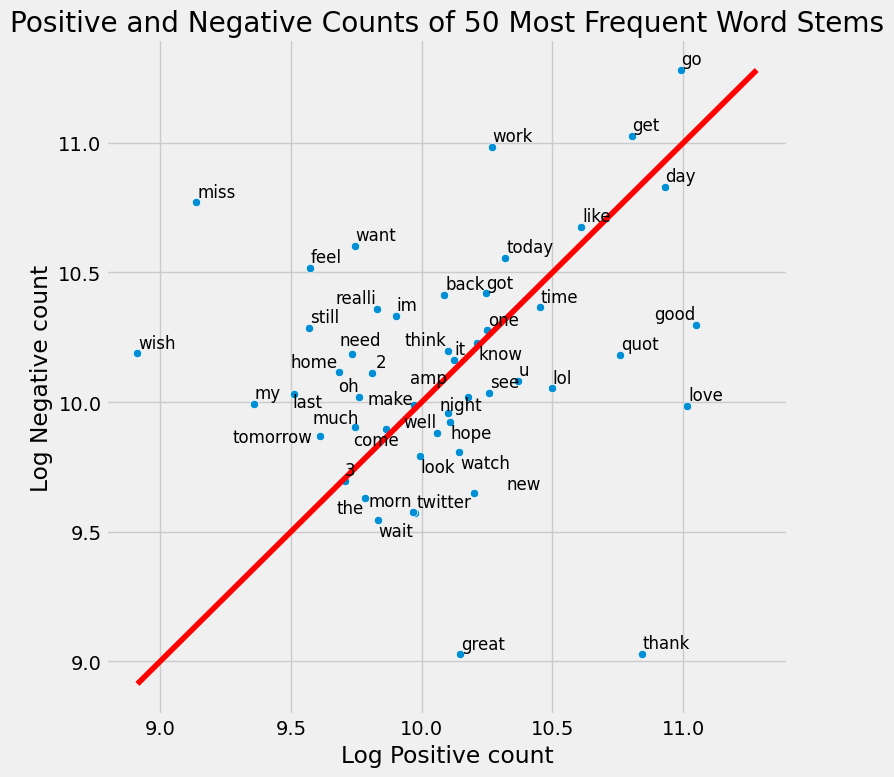

generating sentiment counts plot...10.00 seconds


In [361]:
@measure_time("generating sentiment counts plot")
def generate_sentiment_counts_plot(freqs_sorted, n=50):
    # Get unique list of words from keys in freqs_sorted
    word_list = list(set(word for word, sentiment in freqs_sorted.keys()))

    # Build list of words with positive and negative sentiment counts
    data = [
        [word, freqs_sorted.get((word, 1), 0), freqs_sorted.get((word, 0), 0)]
        for word in word_list
        # Remove 'i' since it is an outlier
        if word != "i"
    ]

    # Sort data by the sum of positive and negative counts and limit to top 'n' most frequent words
    data = sorted(data, key=lambda x: x[1] + x[2], reverse=True)[:n]

    # Prepare x and y for plot, apply log transformation for large counts
    x = np.log([x[1] + 1 for x in data])
    y = np.log([x[2] + 1 for x in data])

    # Create scatter plot for log-transformed counts
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=x, y=y)
    plt.title(f"Positive and Negative Counts of {n} Most Frequent Word Stems")
    plt.xlabel("Log Positive count")
    plt.ylabel("Log Negative count")

    # Add annotations to each point in scatter plot, adjust to avoid overlap
    texts = []
    for i in range(len(data)):
        texts.append(plt.text(x[i], y[i], data[i][0], fontsize=12))

    adjust_text(texts)

    # Add red line from minimum to maximum value on both axes
    min_val = min(np.min(x), np.min(y))
    max_val = max(np.max(x), np.max(y))
    plt.plot([min_val, max_val], [min_val, max_val], color="red")

    # Save visualization
    plt.tight_layout()
    plt.savefig("report/positive_and_negative_counts.png", dpi=300)

    plt.show()

# Call the function
generate_sentiment_counts_plot(freqs_sorted)

## Build & Evaluate Models

### Weights & Biases (`wandb`) Setup


In [362]:
%%capture
wandb.login(key=os.getenv("WANDB_API_KEY"))

### Model Evaluation ###

In [365]:
def evaluateClassicalModel(classifier, xtest, ytest, class_labels, avg="macro", multiclass=False):
    """
    Evaluate a classical machine learning model on the given test data and logs metrics and results to wandb.

    Args:
        classifier (object): An object with a 'model' attribute which supports the 'predict' method.
        xtest (array-like): Test feature data.
        ytest (array-like): True labels for test data.
        class_labels (list): List of class labels for classification.
        avg (str, optional): Averaging method to calculate metrics for multiclass classification. 
                             Defaults to 'macro'.
        multiclass (bool, optional): Indicates if the classifier is multiclass or binary. Defaults to False.

    Outputs:
        Prints accuracy, precision, recall, F1 score, and if applicable, a detailed classification report.
        Displays a heatmap of the confusion matrix.
        Logs metrics, confusion matrix, and classification report (if multiclass) to wandb.
        Logs the classifier model to wandb as an artifact.

    Notes:
        - The function uses wandb for logging and assumes you have already initiated a wandb run.
        - For multiclass classification, metrics are computed using the specified 'avg' method.
        - For binary classification, standard metrics computations are used.
    """
    with wandb.init(
        project="brand-sentiment-analysis",
        config={"model": classifier.model},
        name=f"{datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}_{classifier.model}",
    ) as run:
        # Make predictions
        predictions = classifier.model.predict(xtest)

        # Metrics - if classifier is multiclass, specify averaging method
        accuracy = accuracy_score(ytest, predictions)
        if multiclass:
            precision = precision_score(ytest, predictions, average=avg)
            recall = recall_score(ytest, predictions, average=avg)
            f1 = f1_score(ytest, predictions, average=avg)
        else:
            precision = precision_score(ytest, predictions)
            recall = recall_score(ytest, predictions)
            f1 = f1_score(ytest, predictions)

        candidate = (classifier, f1)
        if multiclass and candidate not in brand_classifiers:
            brand_classifiers.append(candidate)
        elif not multiclass and candidate not in sentiment_classifiers:
            sentiment_classifiers.append(candidate)

        # Print metrics
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1: {f1:.4f}")
        if multiclass:
            print(f"Metrics obtained using {avg} average")

        if multiclass:
            report = classification_report(
                ytest, predictions, target_names=class_labels, output_dict=True
            )

            report_df = pd.DataFrame(report).transpose()
            report_df.drop(["macro avg", "weighted avg", "accuracy"], inplace=True)
            report_df = report_df.reset_index().rename(columns={'index': 'class_name'})
            report_df = report_df.sort_values("f1-score", ascending=False).reset_index(drop=True)
            tbl = wandb.Table(data=report_df)
            display(report_df)
            
        
        # Construct confusion matrix
        cm = confusion_matrix(ytest, predictions)
        plt.figure(figsize=(14, 12))
        sns.heatmap(
            cm, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels
        )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

        if not multiclass:
            ytest = np.array(ytest)

        # Log to wandb
        wandb.log(
            {
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "confusion_matrix": 
                wandb.plot.confusion_matrix(
                    probs=None, 
                    y_true=ytest, 
                    preds=predictions,
                    class_names=class_labels),
            }
        )
        
        if multiclass:
            wandb.log({"classification_report" : tbl})

        # Log model
        artifact = wandb.Artifact("model", type="model")
        joblib.dump(classifier.model, "model.pkl")
        artifact.add_file("model.pkl")
        run.log_artifact(artifact)
        os.remove("model.pkl")


In [366]:
# Create lists to store classifier candidates
brand_classifiers = []
sentiment_classifiers = []

## Brand Classifer


In [367]:
class BrandClassifier(ABC):
    """
    Abstract base class for brand classifiers.

    Provides a framework for creating brand classifiers with different vectorization methods.
    The derived classes must implement the `vectorize` method.

    Attributes:
        name (str): Name or identifier for the classifier.
        model (object): The classifier model with a 'predict' method.
        label_encoder (object): Encoder object that supports 'inverse_transform' to decode the predicted labels.

    Methods:
        vectorize(X): Abstract method to convert input data to the desired format/vectorization. Must be implemented in derived classes.
        predict(X): Make predictions on the input data and return the decoded labels.
    """

    def __init__(self, name, model, label_encoder):
        """
        Initialize the BrandClassifier with a name, model, and label encoder.

        Args:
            name (str): Name or identifier for the classifier.
            model (object): The classifier model.
            label_encoder (object): Encoder for the model's label outputs.
        """
        self.name = name
        self.model = model
        self.label_encoder = label_encoder

    @abstractmethod
    def vectorize(self, X):
        """
        Abstract method to vectorize input data.

        Args:
            X (array-like): Input data.

        Returns:
            array-like: Vectorized data.
        """
        pass

    def predict(self, X):
        """
        Predict labels for the given input data.

        Args:
            X (array-like): Input data.

        Returns:
            array-like: Predicted labels after decoding using the label encoder.
        """
        X_vectorized = self.vectorize(X)
        predictions = self.model.predict(X_vectorized)
        return self.label_encoder.inverse_transform(predictions)

In [368]:
class SimpleBrandClassifier(BrandClassifier):
    """
    A simple brand classifier derived from the BrandClassifier base class.

    This class utilizes a provided vectorizer to convert input data into a format
    suitable for predictions with the given model.

    Attributes:
        vectorizer (object): Object responsible for transforming the input data. 
                             It should support the 'transform' method.

    Methods:
        vectorize(X): Transform input data using the provided vectorizer.
    """

    def __init__(self, name, model, vectorizer, label_encoder):
        """
        Initialize the SimpleBrandClassifier with a name, model, vectorizer, and label encoder.

        Args:
            name (str): Name or identifier for the classifier.
            model (object): The classifier model.
            vectorizer (object): Object responsible for transforming the input data.
            label_encoder (object): Encoder for the model's label outputs.
        """
        super().__init__(name, model, label_encoder)
        self.vectorizer = vectorizer

    def vectorize(self, X):
        """
        Transform the input data using the provided vectorizer.

        Args:
            X (array-like): Input data.

        Returns:
            array-like: Transformed or vectorized data.
        """
        return self.vectorizer.transform(X)

### Multinomial Naive Bayes using count vectorizer ###

In [369]:
# Extract tweets and brand columns
X = brands_df.tweet
y = brands_df.brand

# Initialize a count vectorizer and a label encoder
vectorizer = CountVectorizer()
label_encoder = LabelEncoder()

# Transform the tweets into a matrix of token counts and encode the brand labels
X_vectorized = vectorizer.fit_transform(X)
y_encoded = label_encoder.fit_transform(y)

# Retrieve the unique brand names (class labels) from the encoder
class_labels = label_encoder.classes_

# Split the dataset into training and test sets, using 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2)

# Initialize a Multinomial Naive Bayes classifier
multinomialNB_count_vectorizer = MultinomialNB()
# Train the classifier on the training data
multinomialNB_count_vectorizer.fit(X_train, y_train)

# Create a SimpleBrandClassifier instance using the trained MultinomialNB model
mnb_classifier = SimpleBrandClassifier(
    'multinomialNB_count_vectorizer',
    multinomialNB_count_vectorizer,
    vectorizer,
    label_encoder
)


Accuracy: 0.8272
Precision: 0.9279
Recall: 0.7039
F1: 0.7883
Metrics obtained using macro average


,class_name,precision,recall,f1-score,support
0,facebook,0.880531,0.879234,0.879882,679.0
1,google,0.903448,0.829114,0.864686,474.0
2,apple,0.902256,0.816327,0.857143,441.0
3,nobrand,0.746500,0.939077,0.831788,2101.0
4,disney,0.963158,0.703846,0.813333,260.0
5,starbucks,0.937824,0.630662,0.754167,287.0
6,microsoft,0.978495,0.610738,0.752066,149.0
7,amazon,1.000000,0.597122,0.747748,139.0
8,walmart,1.000000,0.595092,0.746154,163.0
9,target,0.969072,0.573171,0.720307,164.0


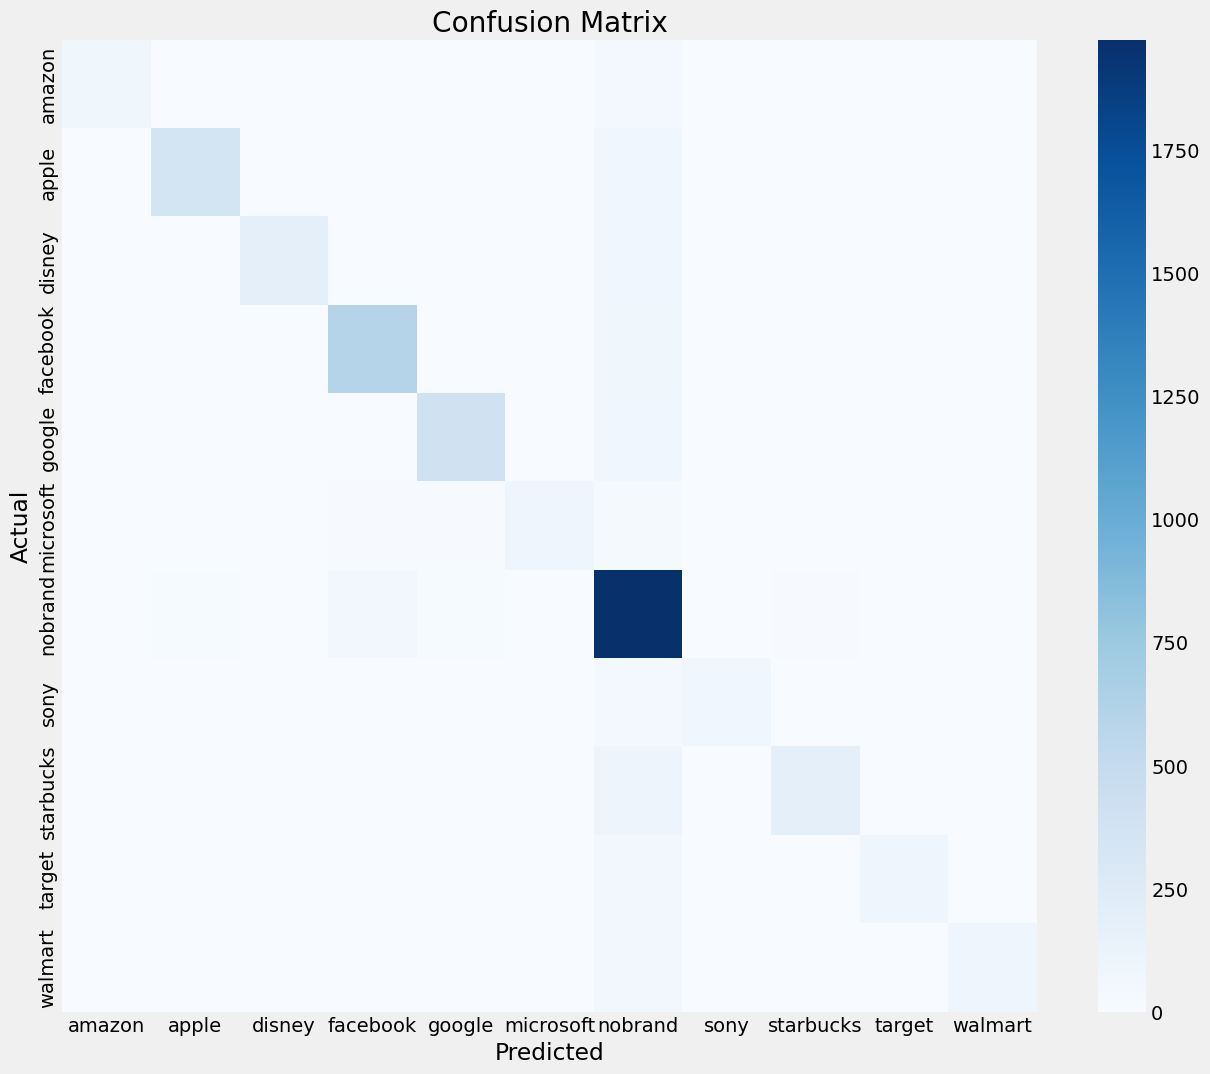

accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.82722
f1,0.78832
precision,0.92793
recall,0.70387


In [370]:
# Evaluate model
evaluateClassicalModel(
    mnb_classifier, 
    X_test, 
    y_test, 
    class_labels, 
    multiclass=True
)

In [371]:
# Quick test
new_tweets = [
    "apple is the best company",
    "I love apples",
    "Apples are the worst",
    "I like apple?",
]

new_tweets_vectorized = vectorizer.transform(new_tweets)
test_prediction = multinomialNB_count_vectorizer.predict(new_tweets_vectorized)
new_predicted_brand_name = label_encoder.inverse_transform(test_prediction)

for tweet, prediction in zip(new_tweets, new_predicted_brand_name):
    print(f"Test tweet: {tweet} -> predicted class: {prediction}")

Test tweet: apple is the best company -> predicted class: apple
Test tweet: I love apples -> predicted class: nobrand
Test tweet: Apples are the worst -> predicted class: apple
Test tweet: I like apple? -> predicted class: apple


### LinearSVC using count vectorizer

In [372]:
# Extract tweets and brands columns
X = brands_df.tweet
y = brands_df.brand

# Initialize a count vectorizer and a label encoder
vectorizer = CountVectorizer()
label_encoder = LabelEncoder()

# Vectorize the tweets and encode the brand labels
X_vectorized = vectorizer.fit_transform(X)
y_encoded = label_encoder.fit_transform(y)

# Retrieve the class labels from the encoder (i.e., unique brand names)
class_labels = label_encoder.classes_

# Split the data into training and test sets, using 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2)

# Initialize a LinearSVC model
svc_count_vectorizer = LinearSVC()
# Train the model using the training data
svc_count_vectorizer.fit(X_train, y_train)

# Create a SimpleBrandClassifier instance with the trained LinearSVC model
svc_classifier = SimpleBrandClassifier(
    'svc_count_vectorizer',
    svc_count_vectorizer,
    vectorizer,
    label_encoder
)

Accuracy: 0.9982
Precision: 0.9970
Recall: 0.9982
F1: 0.9976
Metrics obtained using macro average


,class_name,precision,recall,f1-score,support
0,starbucks,1.000000,1.000000,1.000000,304.0
1,target,1.000000,1.000000,1.000000,148.0
2,facebook,0.998437,1.000000,0.999218,639.0
3,nobrand,0.999527,0.997637,0.998581,2116.0
4,disney,0.996269,1.000000,0.998131,267.0
5,google,0.995943,1.000000,0.997967,491.0
6,microsoft,1.000000,0.994152,0.997067,171.0
7,amazon,0.993103,1.000000,0.996540,144.0
8,apple,0.997691,0.995392,0.996540,434.0
9,walmart,0.992647,1.000000,0.996310,135.0


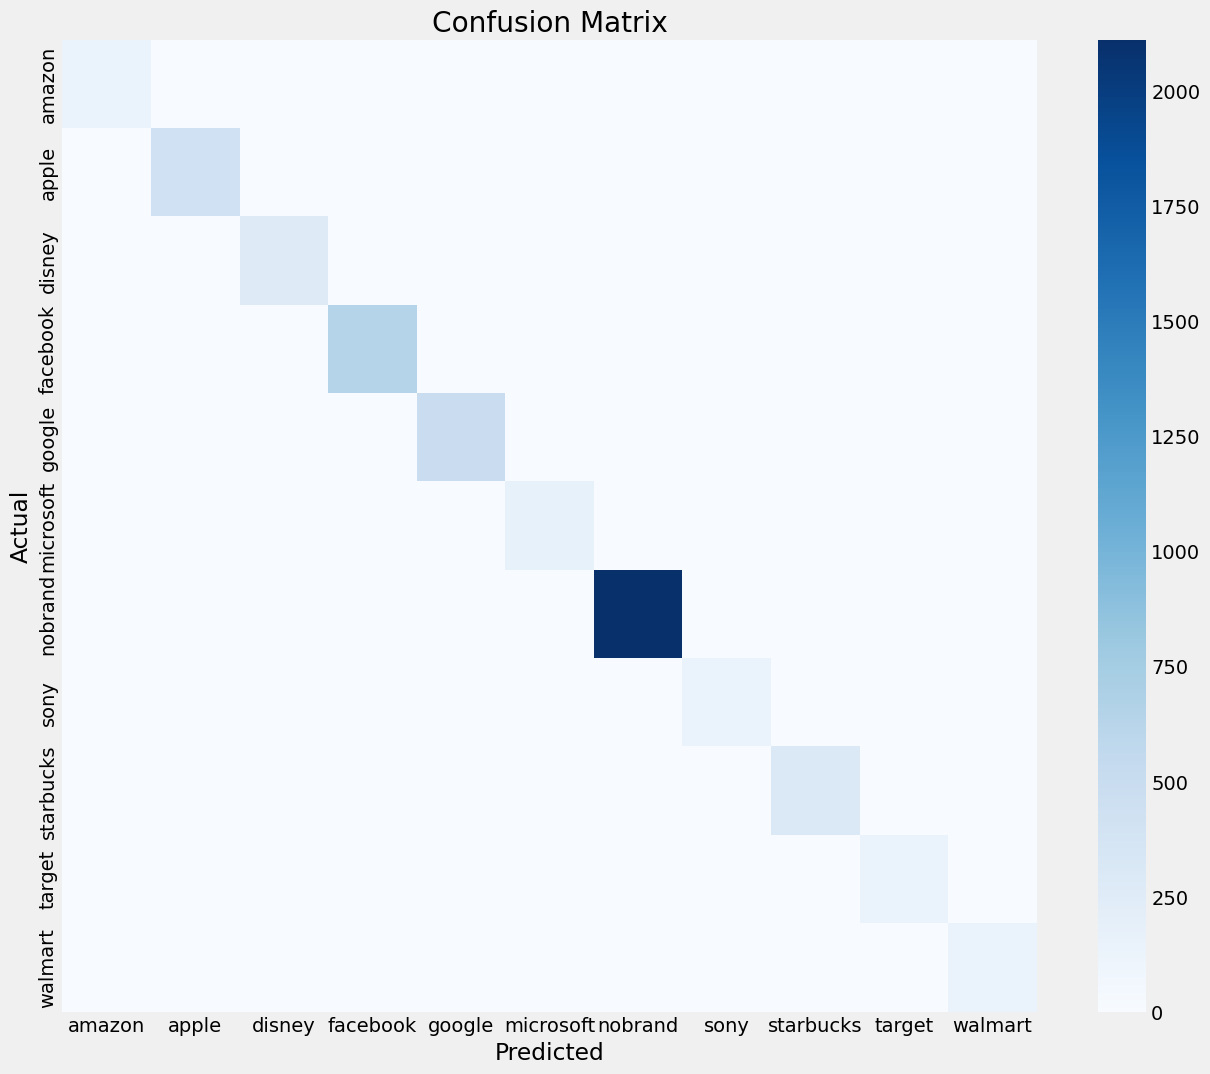

accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.9982
f1,0.99756
precision,0.99695
recall,0.99819


In [373]:
# Evaluate model
evaluateClassicalModel(
    svc_classifier, 
    X_test, 
    y_test, 
    class_labels, 
    multiclass=True
)

### Logistic Regression using word2vec vector embedding ###

In [374]:
class Word2VecBrandClassifier(BrandClassifier):
    """
    A brand classifier that uses Word2Vec embeddings for feature representation.

    This classifier extends the abstract `BrandClassifier` to offer vectorization 
    using the mean Word2Vec embeddings of the words in a given text.

    Attributes:
        word2vec_model (gensim.models.Word2Vec): A pre-trained Word2Vec model for embeddings.

    Methods:
        vectorize(X: Iterable[str]) -> np.array:
            Converts a list of strings into an array of mean Word2Vec embeddings.
    """
    
    def __init__(self, name, model, word2vec_model, label_encoder):
        """
        Initialize a new instance of the Word2VecBrandClassifier.

        Args:
            name (str): The name of the classifier.
            model (sklearn.base.BaseEstimator): The underlying model for classification.
            word2vec_model (gensim.models.Word2Vec): The pre-trained Word2Vec model.
            label_encoder (sklearn.preprocessing.LabelEncoder): Encoder for target labels.
        """
        super().__init__(name, model, label_encoder)
        self.word2vec_model = word2vec_model

    def vectorize(self, X):
        """
        Convert the given list of strings into an array of mean Word2Vec embeddings.

        Args:
            X (Iterable[str]): A list or array-like of strings to be vectorized.

        Returns:
            np.array: An array of mean Word2Vec vectors corresponding to the input strings.
        """
        return np.array([compute_mean_word2vec_vector(self.word2vec_model, x) for x in X])

In [375]:
# Create a deep copy of the original dataframe to apply preprocessing
brands_df_processed = brands_df.copy()
# Apply the preprocessing function (e.g., cleaning, tokenization) to the dataframe
brands_df_processed = apply_preprocessing(brands_df_processed)

# Define the desired size of the word vectors
vector_size = 100
# Initialize and train the Word2Vec model using the processed text from the dataframe
word2vec_model = Word2Vec(
    brands_df_processed.processed_text,
    vector_size=vector_size,
    window=5,
    min_count=1,
    workers=4,
    sg=0,
)

def compute_mean_word2vec_vector(word2vec_model, words):
    """
    Compute the mean Word2Vec vector for a given set of words.

    Args:
        word2vec_model: Trained Word2Vec model.
        words: List of words to compute the mean vector.

    Returns:
        Mean vector of the provided words or a zero vector if none of the words exist in the model vocabulary.
    """
    # Retrieve word vectors for words that exist in the model's vocabulary
    word_vectors = [
        word2vec_model.wv[word] for word in words if word in word2vec_model.wv
    ]
    # Return the mean of all word vectors if list is not empty; otherwise, return a zero vector
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Compute and store mean Word2Vec vectors for each processed text in the dataframe
brands_df_processed["word2vec_vector"] = brands_df_processed.processed_text.apply(
    lambda x: compute_mean_word2vec_vector(word2vec_model, x)
)

# Initialize the label encoder for target variable encoding
label_encoder = LabelEncoder()

# Convert Word2Vec vectors in the dataframe into a NumPy array for model training
x = np.vstack(brands_df_processed["word2vec_vector"].values)
# Encode brand names as integers for model training
y = label_encoder.fit_transform(brands_df_processed["brand"])

# Retrieve the class labels (brand names) from the label encoder
class_labels = label_encoder.classes_

# Split the dataset into training and testing sets (80% training, 20% testing)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

# Initialize and train a logistic regression model using the Word2Vec features
logisticRegression_word2vec = LogisticRegression(max_iter=1000)
logisticRegression_word2vec.fit(xtrain, ytrain)

preprocessing training data...2.30 seconds


LogisticRegression(max_iter=1000)

In [376]:
# Create a Word2VecBrandClassifier
lrw2v_classifier = Word2VecBrandClassifier(
    'logisticRegression_word2vec',
    logisticRegression_word2vec,
    word2vec_model,
    label_encoder
)

Accuracy: 0.8767
Precision: 0.8755
Recall: 0.7459
F1: 0.7976
Metrics obtained using macro average


,class_name,precision,recall,f1-score,support
0,facebook,0.964174,0.953775,0.958947,649.0
1,apple,0.968675,0.945882,0.957143,425.0
2,google,0.949367,0.951374,0.950370,473.0
3,disney,0.915323,0.866412,0.890196,262.0
4,nobrand,0.826623,0.960382,0.888496,2095.0
5,starbucks,0.933594,0.766026,0.841549,312.0
6,sony,0.870370,0.657343,0.749004,143.0
7,microsoft,0.927273,0.607143,0.733813,168.0
8,amazon,0.785714,0.550000,0.647059,140.0
9,walmart,0.742268,0.486486,0.587755,148.0


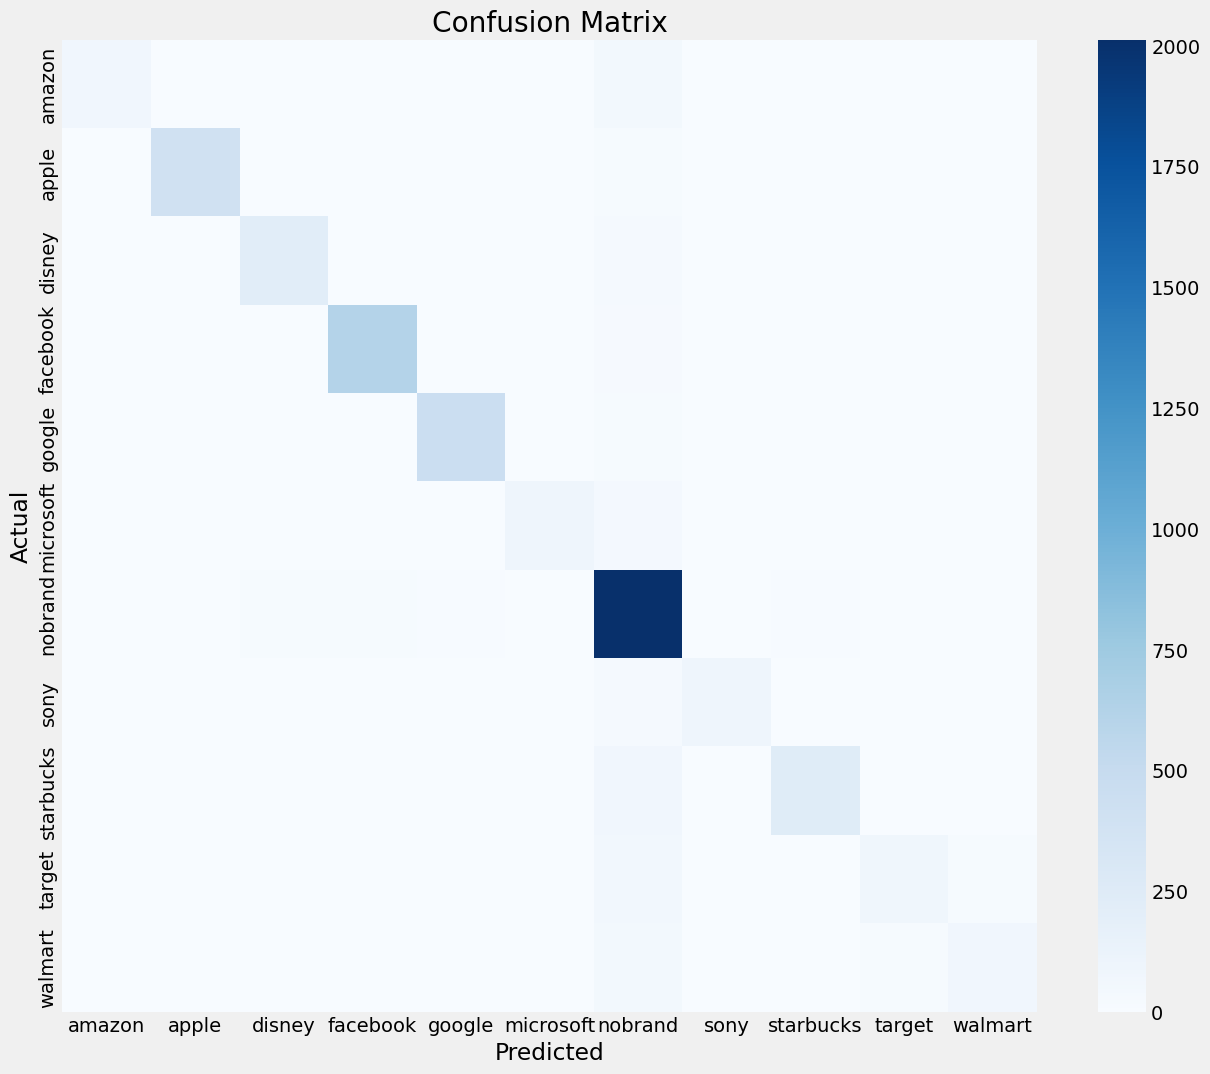

accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.87673
f1,0.79761
precision,0.87555
recall,0.74587


In [377]:
# Evaluate model
evaluateClassicalModel(
    lrw2v_classifier, 
    xtest, 
    ytest, 
    class_labels, 
    multiclass=True
)

In [378]:
# Sort candidate brand classifiers by f1 score
sorted_brand_classifiers = sorted(brand_classifiers, key=lambda x: x[1], reverse=True)
print(sorted_brand_classifiers)

[(<__main__.SimpleBrandClassifier object at 0x3b57e2fd0>, 0.9975646807899179), (<__main__.Word2VecBrandClassifier object at 0x3f5683a00>, 0.7976115096782922), (<__main__.SimpleBrandClassifier object at 0x3a599fe50>, 0.7883180468043244)]


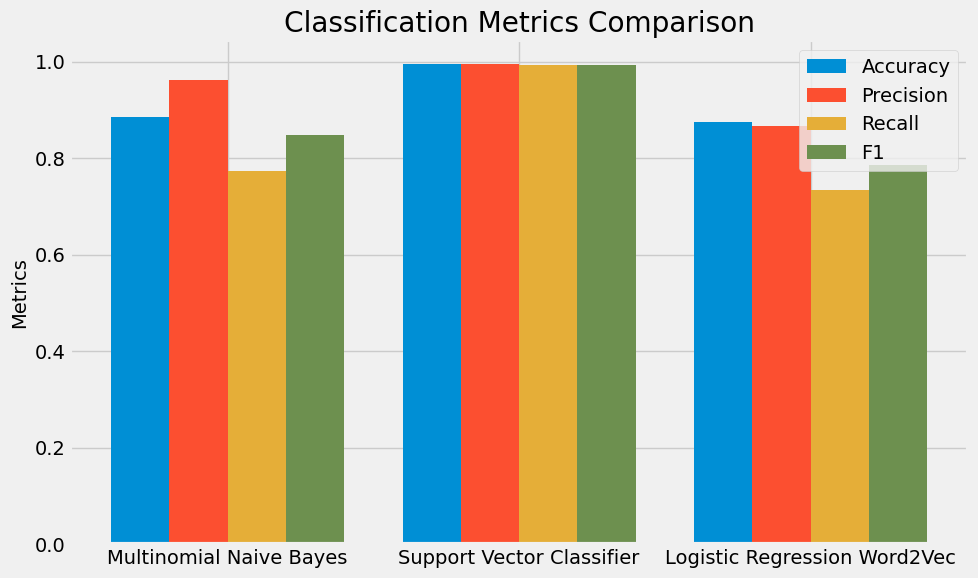

In [ ]:
# Metrics data
approaches = ['Multinomial Naive Bayes', 'Support Vector Classifier', 'Logistic Regression Word2Vec']
accuracy = [0.8861, 0.9948, 0.8747]
precision = [0.9624, 0.9946, 0.8679]
recall = [0.7734, 0.9930, 0.7334]
f1 = [0.8482, 0.9938, 0.7868]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(approaches))
width = 0.2

ax.bar(x, accuracy, width, label='Accuracy')
ax.bar([i + width for i in x], precision, width, label='Precision')
ax.bar([i + width * 2 for i in x], recall, width, label='Recall')
ax.bar([i + width * 3 for i in x], f1, width, label='F1')

ax.set_xticks([i + width * 1.5 for i in x])
ax.set_xticklabels(approaches)
ax.set_ylabel('Metrics')
ax.set_title('Classification Metrics Comparison')
ax.legend()

plt.tight_layout()
plt.show()

## Sentiment Classifier

In [379]:
class SentimentClassifier(ABC):
    """
    Abstract base class for sentiment classification models.

    Attributes:
        name (str): A unique identifier or name for the classifier.
        model (obj): The underlying trained model object used for predictions.

    Methods:
        vectorize(X): Abstract method to convert raw input (e.g., text) into a format suitable for prediction.
        predict(X): Make a prediction on the input data after vectorization.
    """

    @abstractmethod
    def __init__(self, name, model):
        """
        Initializes the SentimentClassifier with a given name and model.

        Args:
            name (str): A unique identifier or name for the classifier.
            model (obj): The trained model object used for predictions.
        """
        self.name = name
        self.model = model
    
    @abstractmethod
    def vectorize(self, X):
        """
        Abstract method to convert raw input into a format suitable for prediction.

        Args:
            X (iterable): Raw input data to be vectorized.

        Returns:
            The vectorized format of the input data.
        """
        pass
    
    def predict(self, X):
        """
        Make a prediction on the input data.

        Args:
            X (iterable): Raw input data to be predicted.

        Returns:
            ndarray: Predicted labels or values for the input data.
        """
        X_vectorized = self.vectorize(X)
        return self.model.predict(X_vectorized)

### Logistic Regression using tdidf vectorizer

In [380]:
class TFIDFSentimentClassifier(SentimentClassifier):
    """
    A sentiment classification model utilizing TF-IDF vectorization.

    Extends the abstract base class SentimentClassifier to provide a concrete implementation 
    of the vectorize method using TF-IDF vectorization.

    Attributes:
        vectorizer (obj): A trained TF-IDF vectorizer object for transforming raw text data.

    Methods:
        vectorize(X): Converts raw input (e.g., text) into a TF-IDF vectorized format.
        predict(X): Inherits from the base class; makes a prediction on the input data after vectorization.
    """

    def __init__(self, name, model, vectorizer):
        """
        Initializes the TFIDFSentimentClassifier with a given name, model, and vectorizer.

        Args:
            name (str): A unique identifier or name for the classifier.
            model (obj): The trained model object used for predictions.
            vectorizer (obj): A trained TF-IDF vectorizer object.
        """
        super().__init__(name, model)
        self.vectorizer = vectorizer

    def vectorize(self, X):
        """
        Convert raw input text data into a TF-IDF vectorized format.

        Args:
            X (iterable): Raw input text data to be vectorized.

        Returns:
            sparse matrix: The TF-IDF vectorized format of the input data.
        """
        return self.vectorizer.transform(X)

In [381]:
# Extract the 'tweet' column as the features and 'sentiment' column as the target from the dataframe
x = tweets_df.tweet
y = tweets_df.sentiment

# Split the data into training and testing sets with 80% of the data for training and 20% for testing
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

# Initialize a TF-IDF vectorizer with specified parameters:
# - Consider both unigrams and bigrams
# - Limit the features to 500,000
lr_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)

# Fit the vectorizer on the training data to build vocabulary and IDF weights
lr_vectorizer.fit(xtrain)

# Transform the training and testing data using the fitted TF-IDF vectorizer
xtrain = lr_vectorizer.transform(xtrain)
xtest = lr_vectorizer.transform(xtest)

# Initialize a logistic regression model
logisticRegression_tfidf = LogisticRegression()

# Train the logistic regression model on the TF-IDF vectorized training data
logisticRegression_tfidf.fit(xtrain, ytrain)


LogisticRegression()

In [382]:
# Create a TFIDFSentimentClassifier
tfidf_classifier = TFIDFSentimentClassifier(
    'logisticRegression_tfidf',
    logisticRegression_tfidf,
    lr_vectorizer
)

Accuracy: 0.8223
Precision: 0.8195
Recall: 0.8272
F1: 0.8233


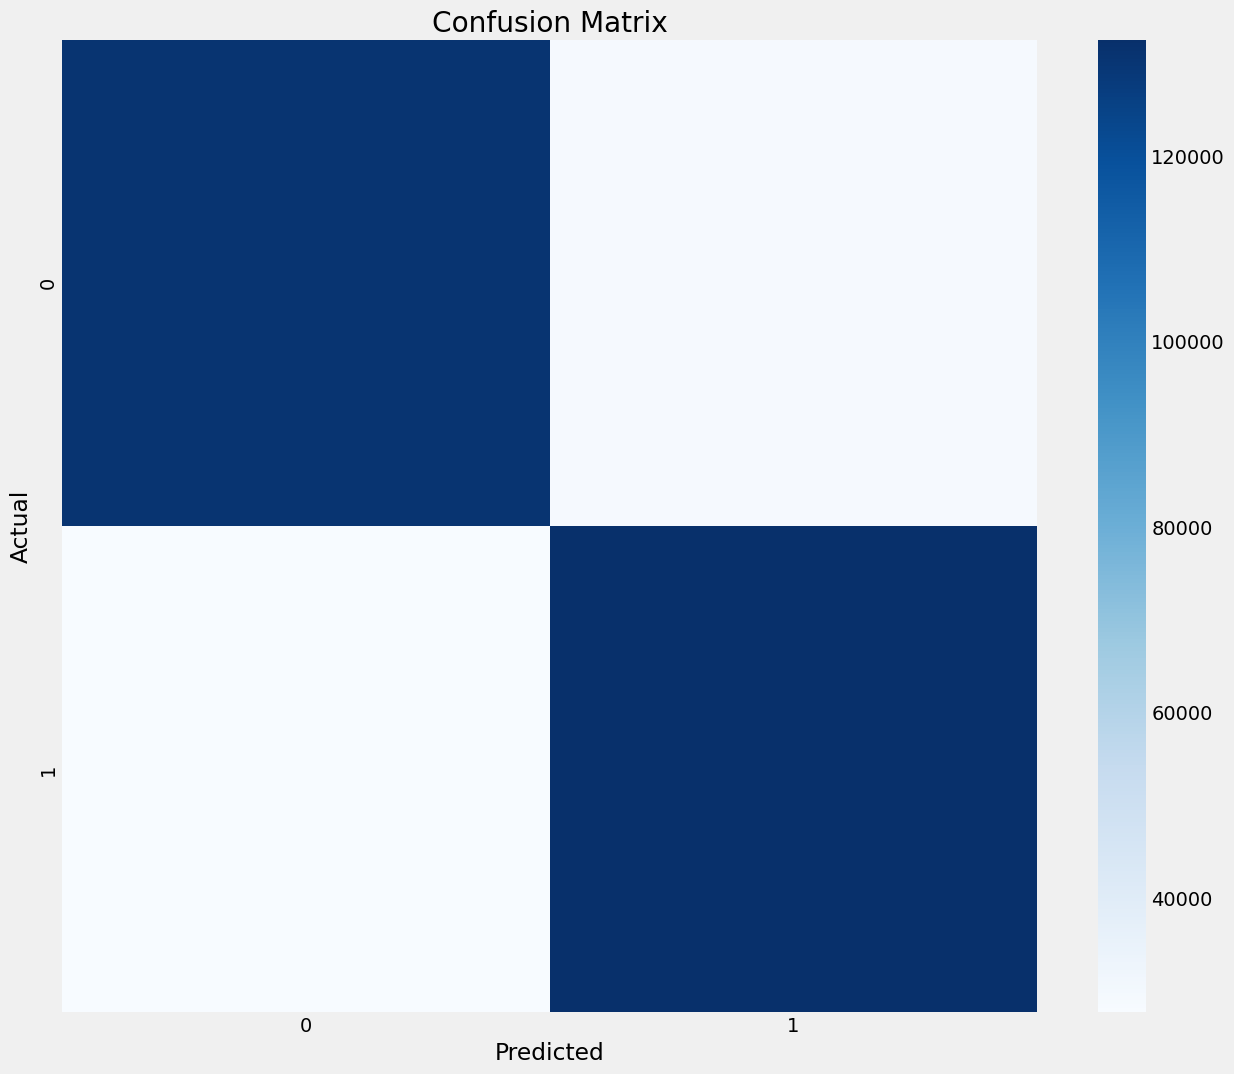

accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.8223
f1,0.82332
precision,0.81947
recall,0.82721


In [383]:
# Evaluate model
evaluateClassicalModel(
    tfidf_classifier,
    xtest, 
    ytest, 
    class_labels=[0, 1]
)

### Logistic Regression using doc2vec vector embedding

In [384]:
class Doc2VecSentimentClassifier(SentimentClassifier):
    """
    A sentiment classifier using the Doc2Vec embedding technique.

    Attributes:
    - name (str): The name of the classifier.
    - model: The machine learning model used for sentiment classification.
    - d2v_model: The trained Doc2Vec model used for embedding the text.

    Methods:
    - vectorize(texts): Converts a list of text strings into Doc2Vec vectors.
    
    Inherits from:
    - SentimentClassifier: An abstract base class for sentiment classifiers.

    Usage:
    ```
    classifier = Doc2VecSentimentClassifier(name="Doc2VecClassifier", model=my_model, d2v_model=my_d2v_model)
    vectorized_texts = classifier.vectorize(["This is a sample text."])
    predictions = classifier.predict(vectorized_texts)
    ```

    """
    
    def __init__(self, name, model, d2v_model):
        """
        Initializes the Doc2VecSentimentClassifier with the given name, classification model, and Doc2Vec model.

        Args:
        - name (str): The name of the classifier.
        - model: The machine learning model used for sentiment classification.
        - d2v_model: The trained Doc2Vec model used for embedding the text.
        """
        super().__init__(name, model)
        self.d2v_model = d2v_model

    def vectorize(self, texts):
        """
        Converts a list of text strings into their corresponding Doc2Vec vectors.

        Args:
        - texts (list of str): The texts to be converted.

        Returns:
        - np.ndarray: An array of Doc2Vec vectors corresponding to the input texts.
        """
        return np.vstack([self.d2v_model.infer_vector(text.split()) for text in texts])

In [385]:
# Make a deep copy of tweets_df
tweets_df_copy = tweets_df.copy()

In [386]:
# Define hyperparameters
vector_size = 100
window = 5
min_count = 1
workers = multiprocessing.cpu_count()
epochs = 10

tagged_documents = [
    TaggedDocument(words=words, tags=[i])
    for i, words in enumerate(tweets_df_copy.processed_text)
]

# Train the model and log metrics
doc2vec_model = Doc2Vec(
    documents=None,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    epochs=0,
)

doc2vec_model.build_vocab(tagged_documents)

for epoch in range(epochs):
    print("Starting epoch...")
    start_time = time.time()
    doc2vec_model.train(
        tagged_documents,
        total_examples=doc2vec_model.corpus_count,
        epochs=1,
    )
    end_time = time.time()
    elapsed_time = end_time - start_time


Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...
Starting epoch...


In [387]:
# Infer vectors for each processed tweet using trained doc2vec model
tweets_df_copy["doc2vec_vector"] = tweets_df_copy.processed_text.apply(
    lambda x: doc2vec_model.infer_vector(x)
)

In [388]:
# Stack the "doc2vec_vector" of each tweet in the dataframe into a single numpy array
x = np.vstack(tweets_df_copy["doc2vec_vector"].values)

# Extract sentiment labels for each tweet from the dataframe
y = tweets_df_copy["sentiment"]

# Split the dataset into a training set (70%) and a test set (30%)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

# Instantiate a logistic regression classifier
logisticRegression_doc2vec = LogisticRegression()

# Train the logistic regression classifier on the training data
logisticRegression_doc2vec.fit(xtrain, ytrain)

LogisticRegression()

In [389]:
# Create sentiment classifier
doc2vec_classifier = Doc2VecSentimentClassifier(
    'logisticRegression_doc2vec',
    logisticRegression_doc2vec,
    doc2vec_model
)

Accuracy: 0.6588
Precision: 0.6467
Recall: 0.6961
F1: 0.6705


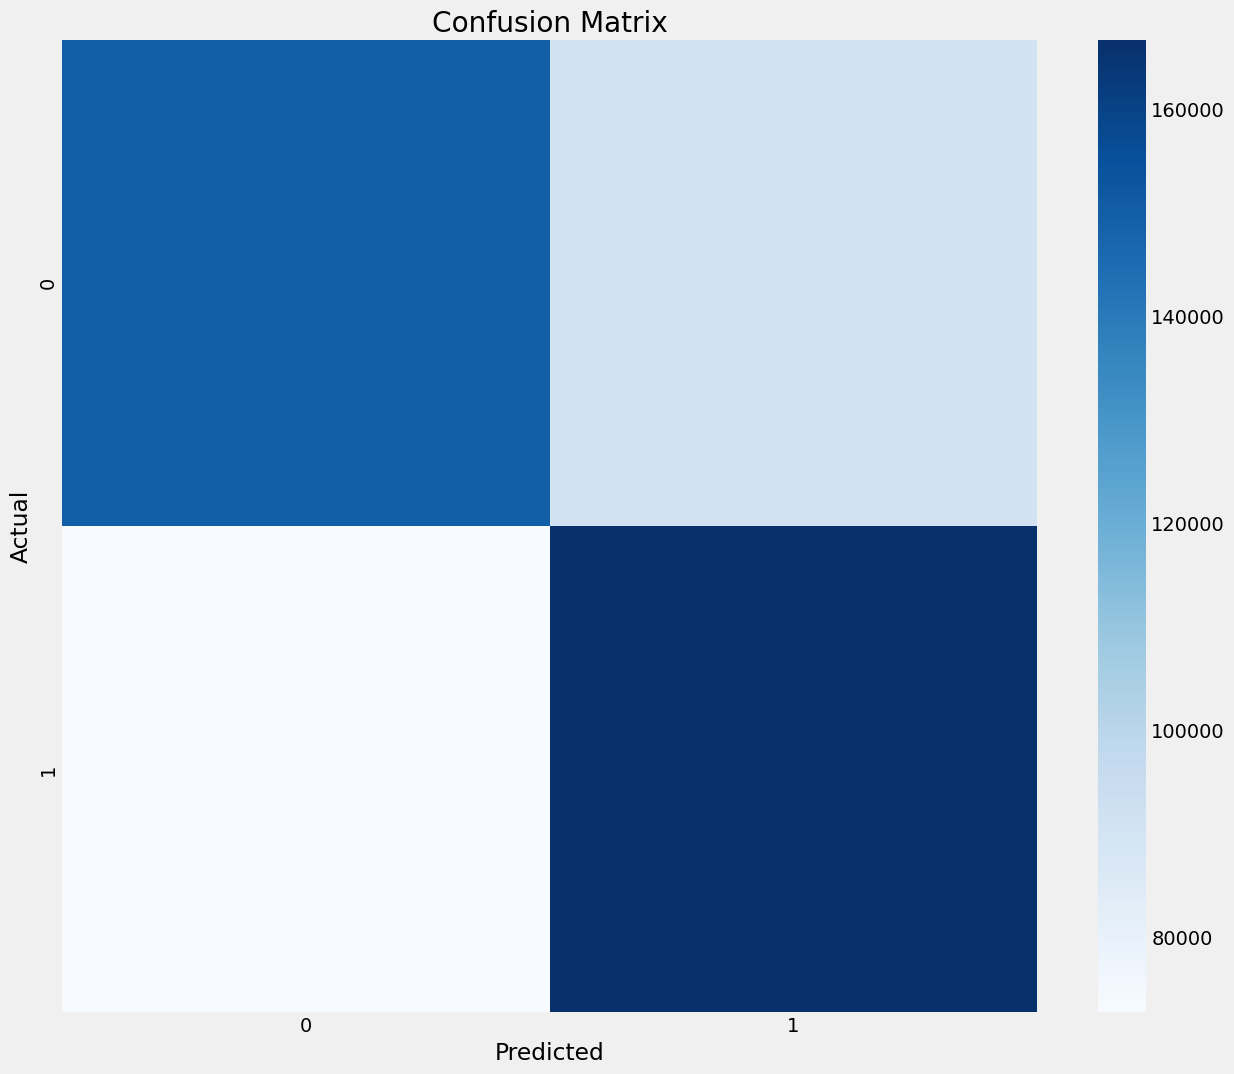

accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.65878
f1,0.67054
precision,0.64674
recall,0.69615


In [390]:
# Evaluate model
evaluateClassicalModel(
    doc2vec_classifier,
    xtest, 
    ytest, 
    class_labels=[0, 1]
)

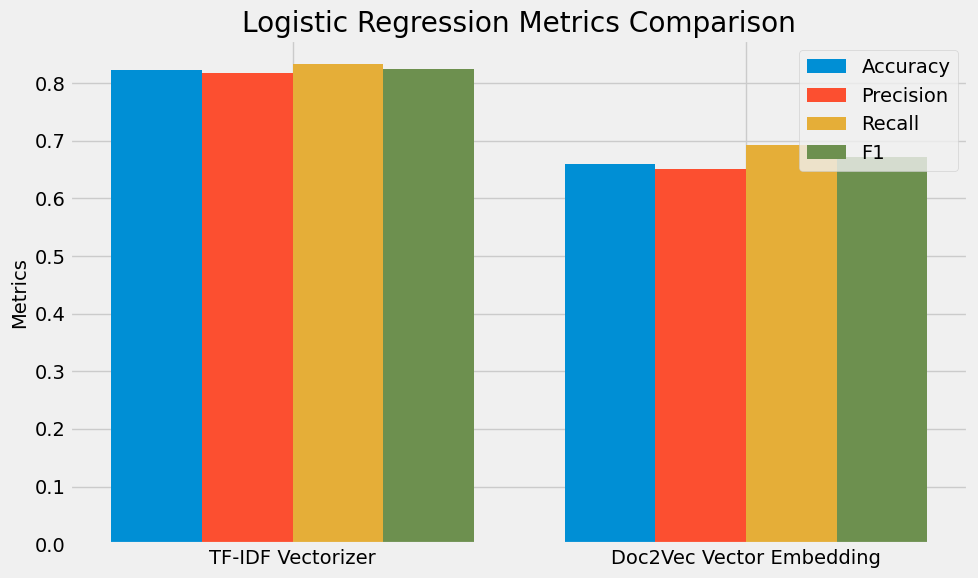

In [ ]:
# Metrics data
approaches = ['TF-IDF Vectorizer', 'Doc2Vec Vector Embedding']
accuracy = [0.8229, 0.6598]
precision = [0.8172, 0.6507]
recall = [0.8328, 0.6928]
f1 = [0.8249, 0.6711]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(approaches))
width = 0.2

ax.bar(x, accuracy, width, label='Accuracy')
ax.bar([i + width for i in x], precision, width, label='Precision')
ax.bar([i + width * 2 for i in x], recall, width, label='Recall')
ax.bar([i + width * 3 for i in x], f1, width, label='F1')

ax.set_xticks([i + width * 1.5 for i in x])
ax.set_xticklabels(approaches)
ax.set_ylabel('Metrics')
ax.set_title('Logistic Regression Metrics Comparison')
ax.legend()

plt.tight_layout()
plt.show()


### Logistic Regression using Universal Sentence Encoder

In [ ]:
# Load the Universal Sentence Encoder
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [396]:
class USESentimentClassifier(SentimentClassifier):
    """
    Sentiment classification model using Logistic Regression with embeddings 
    from the Universal Sentence Encoder (USE).

    Attributes:
        name (str): A unique identifier or name for the classifier.
        model (obj): Logistic Regression model trained on USE embeddings.
        embedder (obj): Universal Sentence Encoder model from TensorFlow Hub.
    """

    def __init__(self, name, model, use_model=embed):
        """
        Initializes the USELogisticRegressionSentimentClassifier with a given name, model, and USE model URL.

        Args:
            name (str): A unique identifier or name for the classifier.
            model (obj): Logistic Regression model trained on USE embeddings.
            use_model_url (str): URL for the Universal Sentence Encoder model on TensorFlow Hub.
        """
        super().__init__(name, model)
        self.embedder = use_model

    def vectorize(self, X):
        """
        Convert raw input text into embeddings using the Universal Sentence Encoder.

        Args:
            X (iterable): List of text strings to be embedded.

        Returns:
            ndarray: Array of embeddings for the input text strings.
        """
        return self.embedder(X).numpy()


In [ ]:
def generate_batch_embeddings(model, batch_texts):
    """
    Generate embeddings for a batch of texts using a given model.

    Args:
        model (callable): The embedding model, e.g., Universal Sentence Encoder.
        batch_texts (list of str): List of texts for which embeddings are to be generated.

    Returns:
        np.ndarray: Array of embeddings corresponding to input texts.
    """
    return model(batch_texts).numpy()

# Define the batch size for processing
batch_size = 1000
embeddings = []

# Process texts in batches to generate embeddings
for i in range(0, len(tweets_df_copy.tweet), batch_size):
    # Extract a batch of tweets
    batch_texts = tweets_df_copy.tweet[i:i+batch_size].tolist()
    
    # Generate embeddings for the batch and append to the list
    embeddings.extend(generate_batch_embeddings(embed, batch_texts))

# Convert list of embeddings to numpy array
x = np.array(embeddings)

# Extract sentiment labels and convert to numpy array
y = tweets_df_copy["sentiment"].to_numpy()

# Split the data into train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

# Initialize the Logistic Regression model
logisticRegression_use = LogisticRegression()

# Train the Logistic Regression model on the training data
logisticRegression_use.fit(xtrain, ytrain)

In [397]:
# Create sentiment classifier
use_classifier = USESentimentClassifier(
    'logisticRegression_use',
    logisticRegression_use
)

Accuracy: 0.7850
Precision: 0.7854
Recall: 0.7850
F1: 0.7852


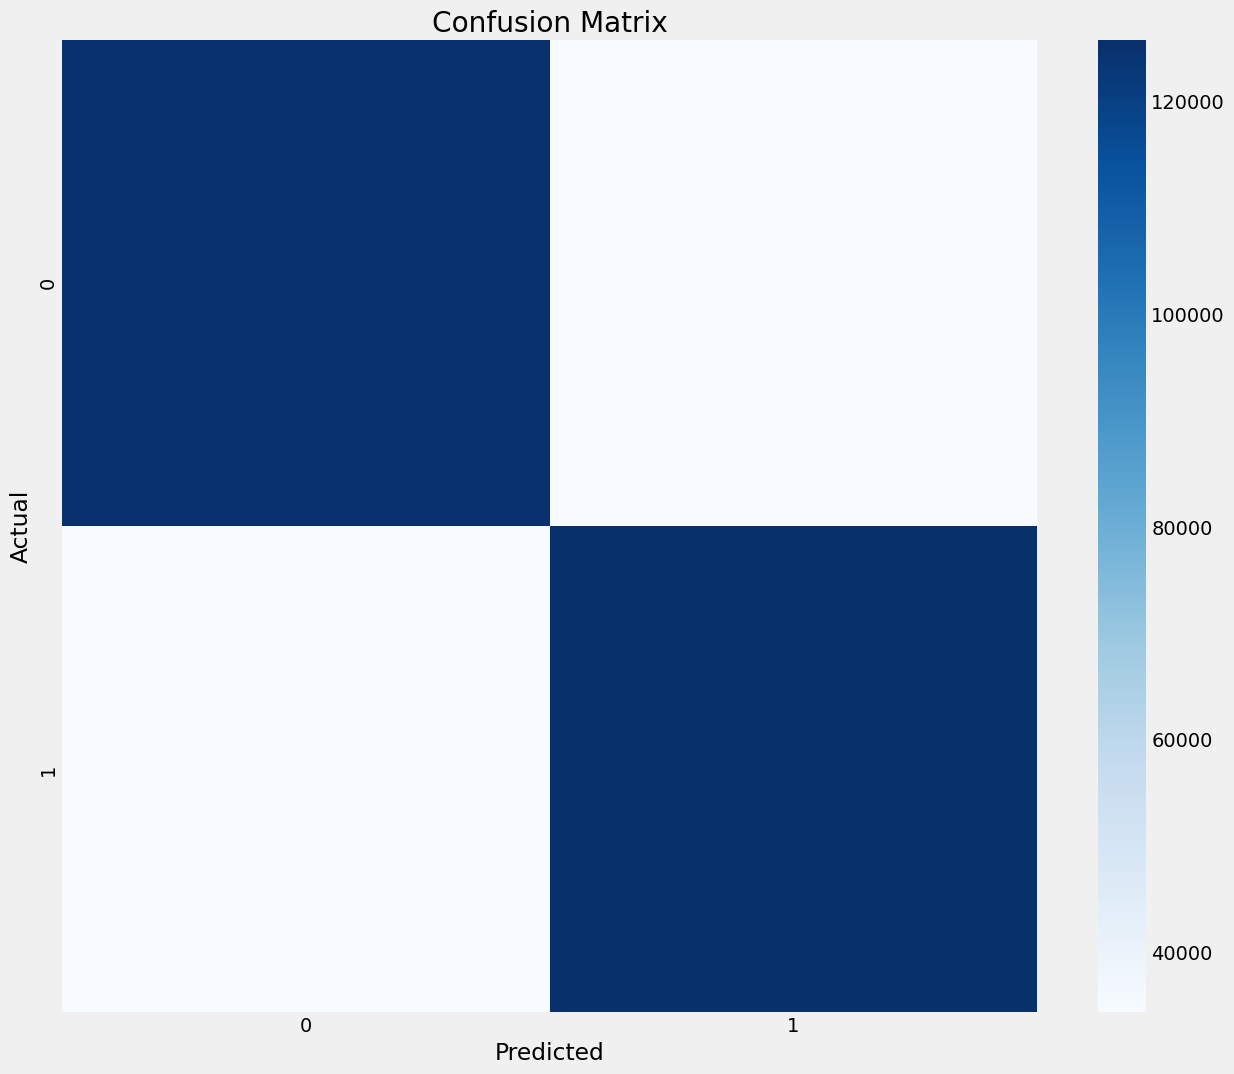

accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.78496
f1,0.78522
precision,0.7854
recall,0.78505


In [398]:
# Evaluate model
evaluateClassicalModel(
    use_classifier,
    xtest, 
    ytest, 
    class_labels=[0, 1]
)

In [399]:
# Sort candidate sentiment classifiers by f1 score
sorted_sentiment_classifiers = sorted(sentiment_classifiers, key=lambda x: x[1], reverse=True)
print(sorted_sentiment_classifiers)

[(<__main__.TFIDFSentimentClassifier object at 0x497f82820>, 0.8233236187836721), (<__main__.USESentimentClassifier object at 0x2b7e5ad30>, 0.7852242579356409), (<__main__.Doc2VecSentimentClassifier object at 0x332da0d90>, 0.6705368583457545)]


## Putting It All Together - Brand Sentiment Analyzer ##


In [400]:
# Choose the brand and sentiment classifier with the highest score
print(f"Brand classifier: {sorted_brand_classifiers[0][0].name}")
brand_classifier = sorted_brand_classifiers[0][0]

print(f"Sentiment classifier: {sorted_sentiment_classifiers[0][0].name}")
sentiment_classifier = sorted_sentiment_classifiers[0][0]

Brand classifier: svc_count_vectorizer
Sentiment classifier: logisticRegression_tfidf


In [401]:
class BrandSentimentAnalyzer:
    """
    Analyzes brand mentions and sentiment from a list of tweets.

    This class combines the predictions of brand classifiers and sentiment classifiers
    to provide a dual analysis: which brand is mentioned and the sentiment of the mention.

    Attributes:
        brand_classifier (object): An object that implements a 'predict' method for brand classification.
        sentiment_classifier (object): An object that implements a 'predict' method for sentiment classification.

    Methods:
        predict(tweets: List[str]) -> List[Tuple[str, str]]:
            Predicts the brand and sentiment for each tweet.
    """
    
    def __init__(self, brand_classifier, sentiment_classifier):
        """
        Initializes the BrandSentimentAnalyzer with the provided classifiers.

        Args:
            brand_classifier (object): Classifier for predicting brands.
            sentiment_classifier (object): Classifier for predicting sentiments.
        """
        self.brand_classifier = brand_classifier
        self.sentiment_classifier = sentiment_classifier

    def predict(self, tweets):
        """
        Predicts the brand and sentiment for each tweet.

        Args:
            tweets (List[str]): A list of tweets for analysis.

        Returns:
            List[Tuple[str, str]]: A list of tuples where each tuple has (brand, sentiment).
        """
        brand_predictions = self.brand_classifier.predict(tweets)
        sentiment_predictions = self.sentiment_classifier.predict(tweets)

        label_map = {0: "Negative", 1: "Positive"}
        sentiment = [label_map[pred] for pred in sentiment_predictions]

        return list(zip(brand_predictions, sentiment))

In [402]:
# Initialize the BrandSentimentAnalyzer with brand and sentiment classifiers.
analyzer = BrandSentimentAnalyzer(brand_classifier, sentiment_classifier)

# Extract tweets from the test dataset for evaluation.
tweets = bsa_test_data.tweet

# Extract the ground truth labels for brands from the test data.
brand_ground_truth = bsa_test_data["brand"]

# Extract the ground truth labels for sentiment and map numerical values to their corresponding string labels.
sentiment_ground_truth = bsa_test_data["sentiment"].replace({0: 'Negative', 1: 'Positive'})

# Use the analyzer to predict brand mentions and sentiment for each tweet in the test dataset.
results = analyzer.predict(tweets)

In [403]:
# Loop through the first 10 actual and predicted results to display them side by side.
for r in zip(tweets, brand_ground_truth.iloc[:10], sentiment_ground_truth.iloc[:10], results[:10]):
    print(f"Actual: {r[0]} ({r[1]}, {r[2]})")
    print(f"-> Predicted: {r[3]}")

# Set initial count values for the total number of tweets, and three types of errors.
n = len(tweets)
error = 0
brand_error = 0
sentiment_error = 0
errors = []

# Loop through all the actual and predicted results.
for r in zip(brand_ground_truth, sentiment_ground_truth, results):
    # If either the brand or sentiment prediction is incorrect, increment error count.
    if r[0] != r[2][0] or r[1] != r[2][1]:
        errors.append(r)
        error += 1
        # If brand prediction is incorrect, increment brand error count.
        if r[0] != r[2][0]:
            brand_error +=1
        # If sentiment prediction is incorrect, increment sentiment error count.
        elif r[1] != r[2][1]:
            sentiment_error += 1

print("\n")
# Calculate and print the overall accuracy and accuracies for brand and sentiment prediction.
print(f"Overall Accuracy: {1 - error/n:.2f} ({n - error}/{n})")
print(f"Accuracy by brand: {1 - brand_error/n:.2f} ({n - brand_error}/{n})")
print(f"Accuracy by sentiment: {1 - sentiment_error/n:.2f} ({n - sentiment_error}/{n})")

Actual: @AClaire1218 Thanks Anna, oh.. of course, i wouldn't want you to make the year in public, either   Hey, do you have a facebook page ? (facebook, Positive)
-> Predicted: ('facebook', 'Positive')
Actual: the Chocolate Cream Frappucion at Starbucks win.  (starbucks, Positive)
-> Predicted: ('starbucks', 'Positive')
Actual: @branhead4lyfe aww...  i be trying (nobrand, Negative)
-> Predicted: ('nobrand', 'Negative')
Actual: @favoritemelody but thats always fun  (nobrand, Positive)
-> Predicted: ('nobrand', 'Positive')
Actual: E3 is boring with all the Microsoft games. I'm waiting 'til Nintendo tomorrow!  (microsoft, Positive)
-> Predicted: ('microsoft', 'Negative')
Actual: @ypforazzi I have your rain today ... but it is early so maybe it will clear up before I go home from work. Somehow I doubt it  (nobrand, Negative)
-> Predicted: ('nobrand', 'Negative')
Actual: @csiriano 24 Prince is amazing! If only my boyfriend didn't have a parasite from the amazon  (amazon, Negative)
-> Predic

In [ ]:
# Print metrics
metrics.print_metrics()

Metrics:
  generating word cloud from training data: 18.46 seconds
  generating sentiment counts plot: 9.45 seconds
  creating brands dataframe: 5.86 seconds
  loading preprocessed data: 3.01 seconds
  preprocessing training data: 2.54 seconds
  getting word sentiment frequencies: 2.44 seconds
  printing sample preprocessed text: 0.04 seconds
Total time: 41.79 seconds
